In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from ast import literal_eval
import re
from scipy import stats
from random import sample
#import scipy.stats as stats
import random
import re
import statistics

In [2]:
plt.style.use('ggplot')

In [3]:
def HLA_cd8_converter(x):
    #define format of datetime
    return x.replace("[","").replace("]","").replace(",", "").replace("'","").split(" ")

def cdr3_lst_converter(x):
    #define format of datetime
    return x.replace("[","").replace("]","").replace("'","").split(" ")

def epitope_converter(x):
    #define format of datetime
    return [y for y in x.replace("[","").replace("]","").replace("\n","").split("'") if (y != '') & (y != ' ')]

def peptide_hla_converter(x):
    return re.findall("\w+\s{1}\w{1}\d+", x.replace("[","").replace("]","").replace("\n","").replace("'",""))

def literal_converter(val):
    # replace NaN with '' and perform literal eval on the rest
    return [] if val == '' else literal_eval(val)

converters = {'peptide_HLA_lst': peptide_hla_converter,
              'umi_count_lst_mhc': literal_eval,
              'umi_count_lst_TRA': literal_converter,'umi_count_lst_TRB': literal_converter,
              'cdr3_lst_TRA': cdr3_lst_converter,
              'cdr3_lst_TRB': cdr3_lst_converter,
              'HLA_lst_mhc': cdr3_lst_converter,'HLA_cd8': HLA_cd8_converter} #

In [4]:
def get_likely_targets(row):
    from itertools import compress
    if (type(row.HLA_cd8) is list) & (type(row.HLA_lst_mhc) is list):
        chec = [item in row.HLA_cd8 for item in row.HLA_lst_mhc]
        idxs = list(compress(range(len(chec)), chec))
        #return [chec, row.HLA_lst_mhc, row.HLA_cd8, idxs]
        #return [row[var][i] for i in idxs]
        if idxs == []:
            return np.nan
        else:
            return [row.HLA_lst_mhc[i] for i in idxs]
    else:
        return np.nan

In [5]:
def sum_umi(row):
    mat.loc[row.peptide_HLA_lst, row.gem] = row.umi_count_lst_mhc

In [6]:
def get_nonsinglet_idxs(duplicated_list):
    dups = collections.defaultdict(list)
    for i, e in enumerate(duplicated_list):
        dups[e].append(i)
    idxs = []
    for k, v in sorted(dups.items()):
        if len(v) > 1:
            idxs += v
    return idxs

In [7]:
def assign_clonotype(tcr_df, clonotype_variables = ['v_gene_TRA','j_gene_TRA','v_gene_TRB','j_gene_TRB','cdr3_comb']):
    
    tcr_df.loc[:, clonotype_variables] = tcr_df.loc[:, clonotype_variables].fillna('unknown')
    new_clonotype = tcr_df.groupby(clonotype_variables).gem.unique().to_frame()
    new_clonotype['n_gems'] = new_clonotype.gem.apply(len)
    new_clonotype.sort_values(by='n_gems', ascending=False, inplace=True)
    dct = new_clonotype.to_dict()['gem']
    for i, k in enumerate(dct.keys(), start=1): 
        dct[k] = i
    return tcr_df.set_index(clonotype_variables).index.map(dct)

#tcr_df['ct'] = assign_clonotype()

In [8]:
def test_dist():
    p1 = summary_df.index[0]
    p2 = summary_df.index[1]
    
    s1 = mat.T[p1].dropna().to_list()
    s2 = mat.T[p2].dropna().to_list()
    
    n = min(len(s1), len(s2))
    m = max(len(s1), len(s2))
    
    if n < 5:
        #if n/(m+0.25) 
        ## If there are too few GEMs to do proper statistics then just compare the mean UMI per GEM
        #a1 = sum(s1)/len(s1)
        #a2 = sum(s2)/len(s2)
        #if a1 > a2:
        #    return True
        return False
    
    p_list = list()
    for _ in range(10):
        l1 = sample(s1, n)
        l2 = sample(s2, n)

        t, p = stats.ttest_ind(l1, l2, equal_var=False, alternative='greater')
        
        p_list.append(p)
    
    if np.median(p_list) <= 0.05:
        return True
    print(sorted(p_list))
    return False

# Input

In [9]:
# OBS old
INPUT = '/Volumes/tuba/herpov/tcr-pmhc-sc-project/data/exp9.2_CAT_IONTORRENT_KMA_AKB/tables/tcr_barcode.cleaned.alive.csv'

In [10]:
#INPUT = '/Volumes/tuba/herpov/tcr-pmhc-sc-project/data/exp9_CAT_IONTORRENT_KMA_AKB/tables/tcr_barcode.cleaned.imputed.csv'

In [11]:
VALID = '/Volumes/tuba/herpov/tcr-pmhc-sc-project/data/exp9.2_CAT_IONTORRENT_KMA_AKB/reports/valid_ct.alive.csv'

In [12]:
TABLE = '/Volumes/tuba/herpov/tcr-pmhc-sc-project/data/exp9.2_CAT_IONTORRENT_KMA_AKB/reports/concordance_gridsearch.alive.csv' #.relative

In [13]:
SIM_TRA = '/Volumes/tuba/herpov/tcr-pmhc-sc-project/data/exp9.2_CAT_IONTORRENT_KMA_AKB/similarity_assessment/cdr3/kernel_similarity_scores/cdr3_a.csv'
SIM_TRB = '/Volumes/tuba/herpov/tcr-pmhc-sc-project/data/exp9.2_CAT_IONTORRENT_KMA_AKB/similarity_assessment/cdr3/kernel_similarity_scores/cdr3_b.csv'

# Output

In [14]:
PLT = '/Volumes/tuba/herpov/tcr-pmhc-sc-project/plots/exp9.2_IONTORRENT_KMA_AKB/grid_search/alive.'

# Load

In [15]:
df = pd.read_csv(INPUT, converters=converters) #

In [16]:
valid_df = pd.read_csv(VALID, converters=converters).fillna('') #.fillna(0)

In [17]:
#tmp.to_csv('/Volumes/tuba/herpov/tcr-pmhc-sc-project/data/exp9_CAT_IONTORRENT_KMA_AKB/reports/valid_ct.csv')

In [18]:
table = pd.read_csv(TABLE,index_col=0) #_archive

In [19]:
sim_tra = pd.read_csv(SIM_TRA, index_col=0).rename(index={'missing':''}, columns={'missing':''})
sim_trb = pd.read_csv(SIM_TRB, index_col=0).rename(index={'missing':''}, columns={'missing':''})

# Assess threshold effects

In [20]:
# Calc relative UMI counts
for ct, grp in df.groupby('ct'):
    print(ct)
    umi_rel = grp.umi_count_mhc / grp.umi_count_mhc.quantile(0.9, interpolation='lower') #.max()
    df.loc[umi_rel.index, 'umi_count_mhc_rel'] = umi_rel

1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0
48.0
49.0
50.0
51.0
52.0
53.0
54.0
55.0
57.0
58.0
59.0
60.0
61.0
62.0
64.0
68.0
70.0
71.0
72.0
73.0
74.0
75.0
76.0
77.0
78.0
79.0
81.0
82.0
83.0
84.0
85.0
86.0
88.0
89.0
90.0
91.0
92.0
93.0
94.0
95.0
96.0
97.0
99.0
100.0
101.0
111.0
113.0
122.0
123.0
124.0
125.0
126.0
129.0
131.0
136.0
141.0
143.0
148.0
150.0
154.0
155.0
156.0
159.0
162.0
167.0
170.0
171.0
173.0
176.0
177.0
178.0
179.0
180.0
183.0
184.0
185.0
189.0
194.0
195.0
196.0
205.0
209.0
211.0
212.0
215.0
216.0
217.0
219.0
224.0
225.0
227.0
228.0
232.0
233.0
234.0
235.0
237.0
241.0
242.0
246.0
247.0
249.0
253.0
256.0
258.0
259.0
262.0
264.0
265.0
268.0
276.0
277.0
279.0
280.0
289.0
291.0
292.0
293.0
294.0
296.0
299.0
301.0
302.0
303.0
305.0
308.0
309.0
312.0
317.0
320.0
322.0
324.0
326.0
330.0
331.0
332.0
334.0


In [21]:
valid_df.pep_match.sum()

1008

In [22]:
valid_df.pep_match.sum() / len(valid_df)

0.5514223194748359

In [23]:
valid_df.ct.unique()

array([ 2.,  1.,  4., 11.,  8.,  3.,  7.,  6.,  5., 26., 13., 17.,  9.,
       32., 19., 33.])

In [24]:
import seaborn as sns
sns.pairplot(table,
             x_vars=['umi_count_mhc','delta_umi_mhc','umi_count_TRB','delta_umi_TRB'],
             y_vars=['accuracy','ratio_retained_gems','ratio_retained_cts'])
plt.savefig(PLT + 'acc_ratio_v_thresholds.png', bbox_inches='tight')

In [25]:
sns.pairplot(table,
             x_vars=['umi_count_mhc','delta_umi_mhc','umi_count_TRB','delta_umi_TRB'],
             y_vars=['accuracy'])
plt.savefig(PLT + 'acc_v_thresholds.png', bbox_inches='tight')

In [26]:
sns.pairplot(table,
             x_vars=['umi_count_mhc','delta_umi_mhc','umi_count_TRB','delta_umi_TRB'],
             y_vars=['umi_count_mhc','delta_umi_mhc','umi_count_TRB','delta_umi_TRB'])
plt.savefig(PLT + 'threshold_v_thresholds.png', bbox_inches='tight')

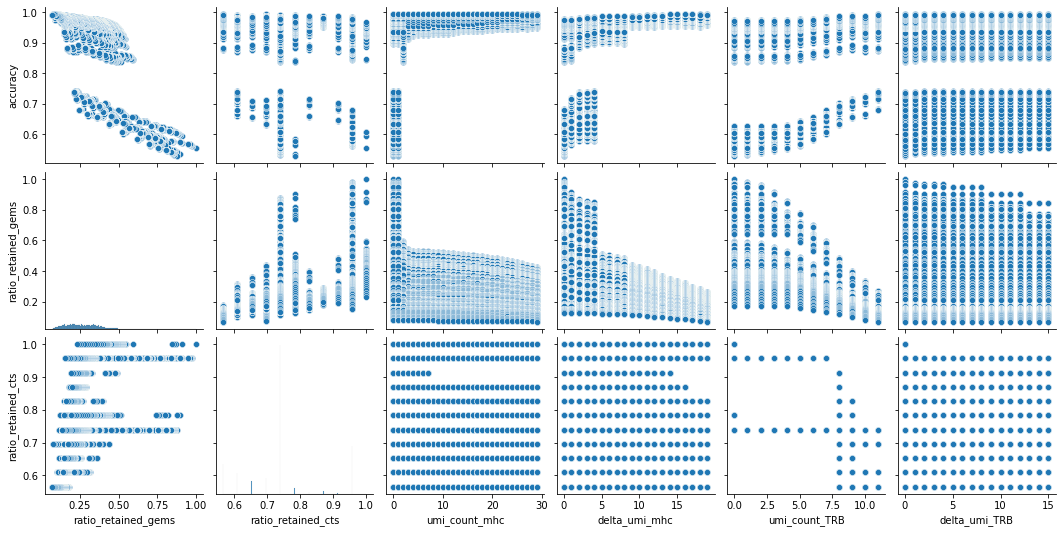

In [18]:
sns.pairplot(table,
             x_vars=['ratio_retained_gems','ratio_retained_cts','umi_count_mhc','delta_umi_mhc','umi_count_TRB','delta_umi_TRB'],
             y_vars=['accuracy','ratio_retained_gems','ratio_retained_cts'])
plt.savefig(PLT + 'acc_ratio_v_threshold_ratio.png', bbox_inches='tight')

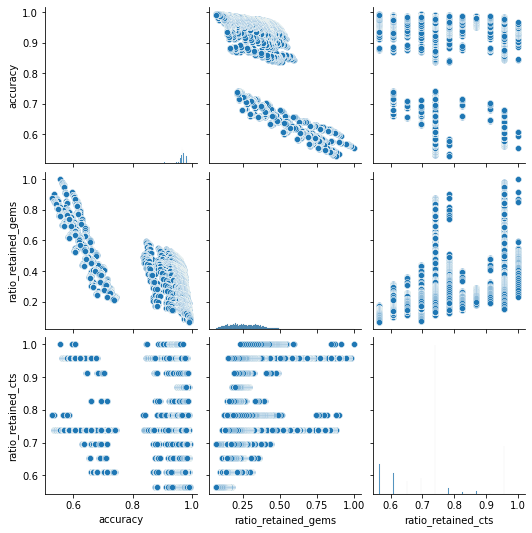

In [19]:
sns.pairplot(table,
             x_vars=['accuracy','ratio_retained_gems','ratio_retained_cts'],
             y_vars=['accuracy','ratio_retained_gems','ratio_retained_cts'])
plt.savefig(PLT + 'acc_ratio_v_acc_ratio.png', bbox_inches='tight')

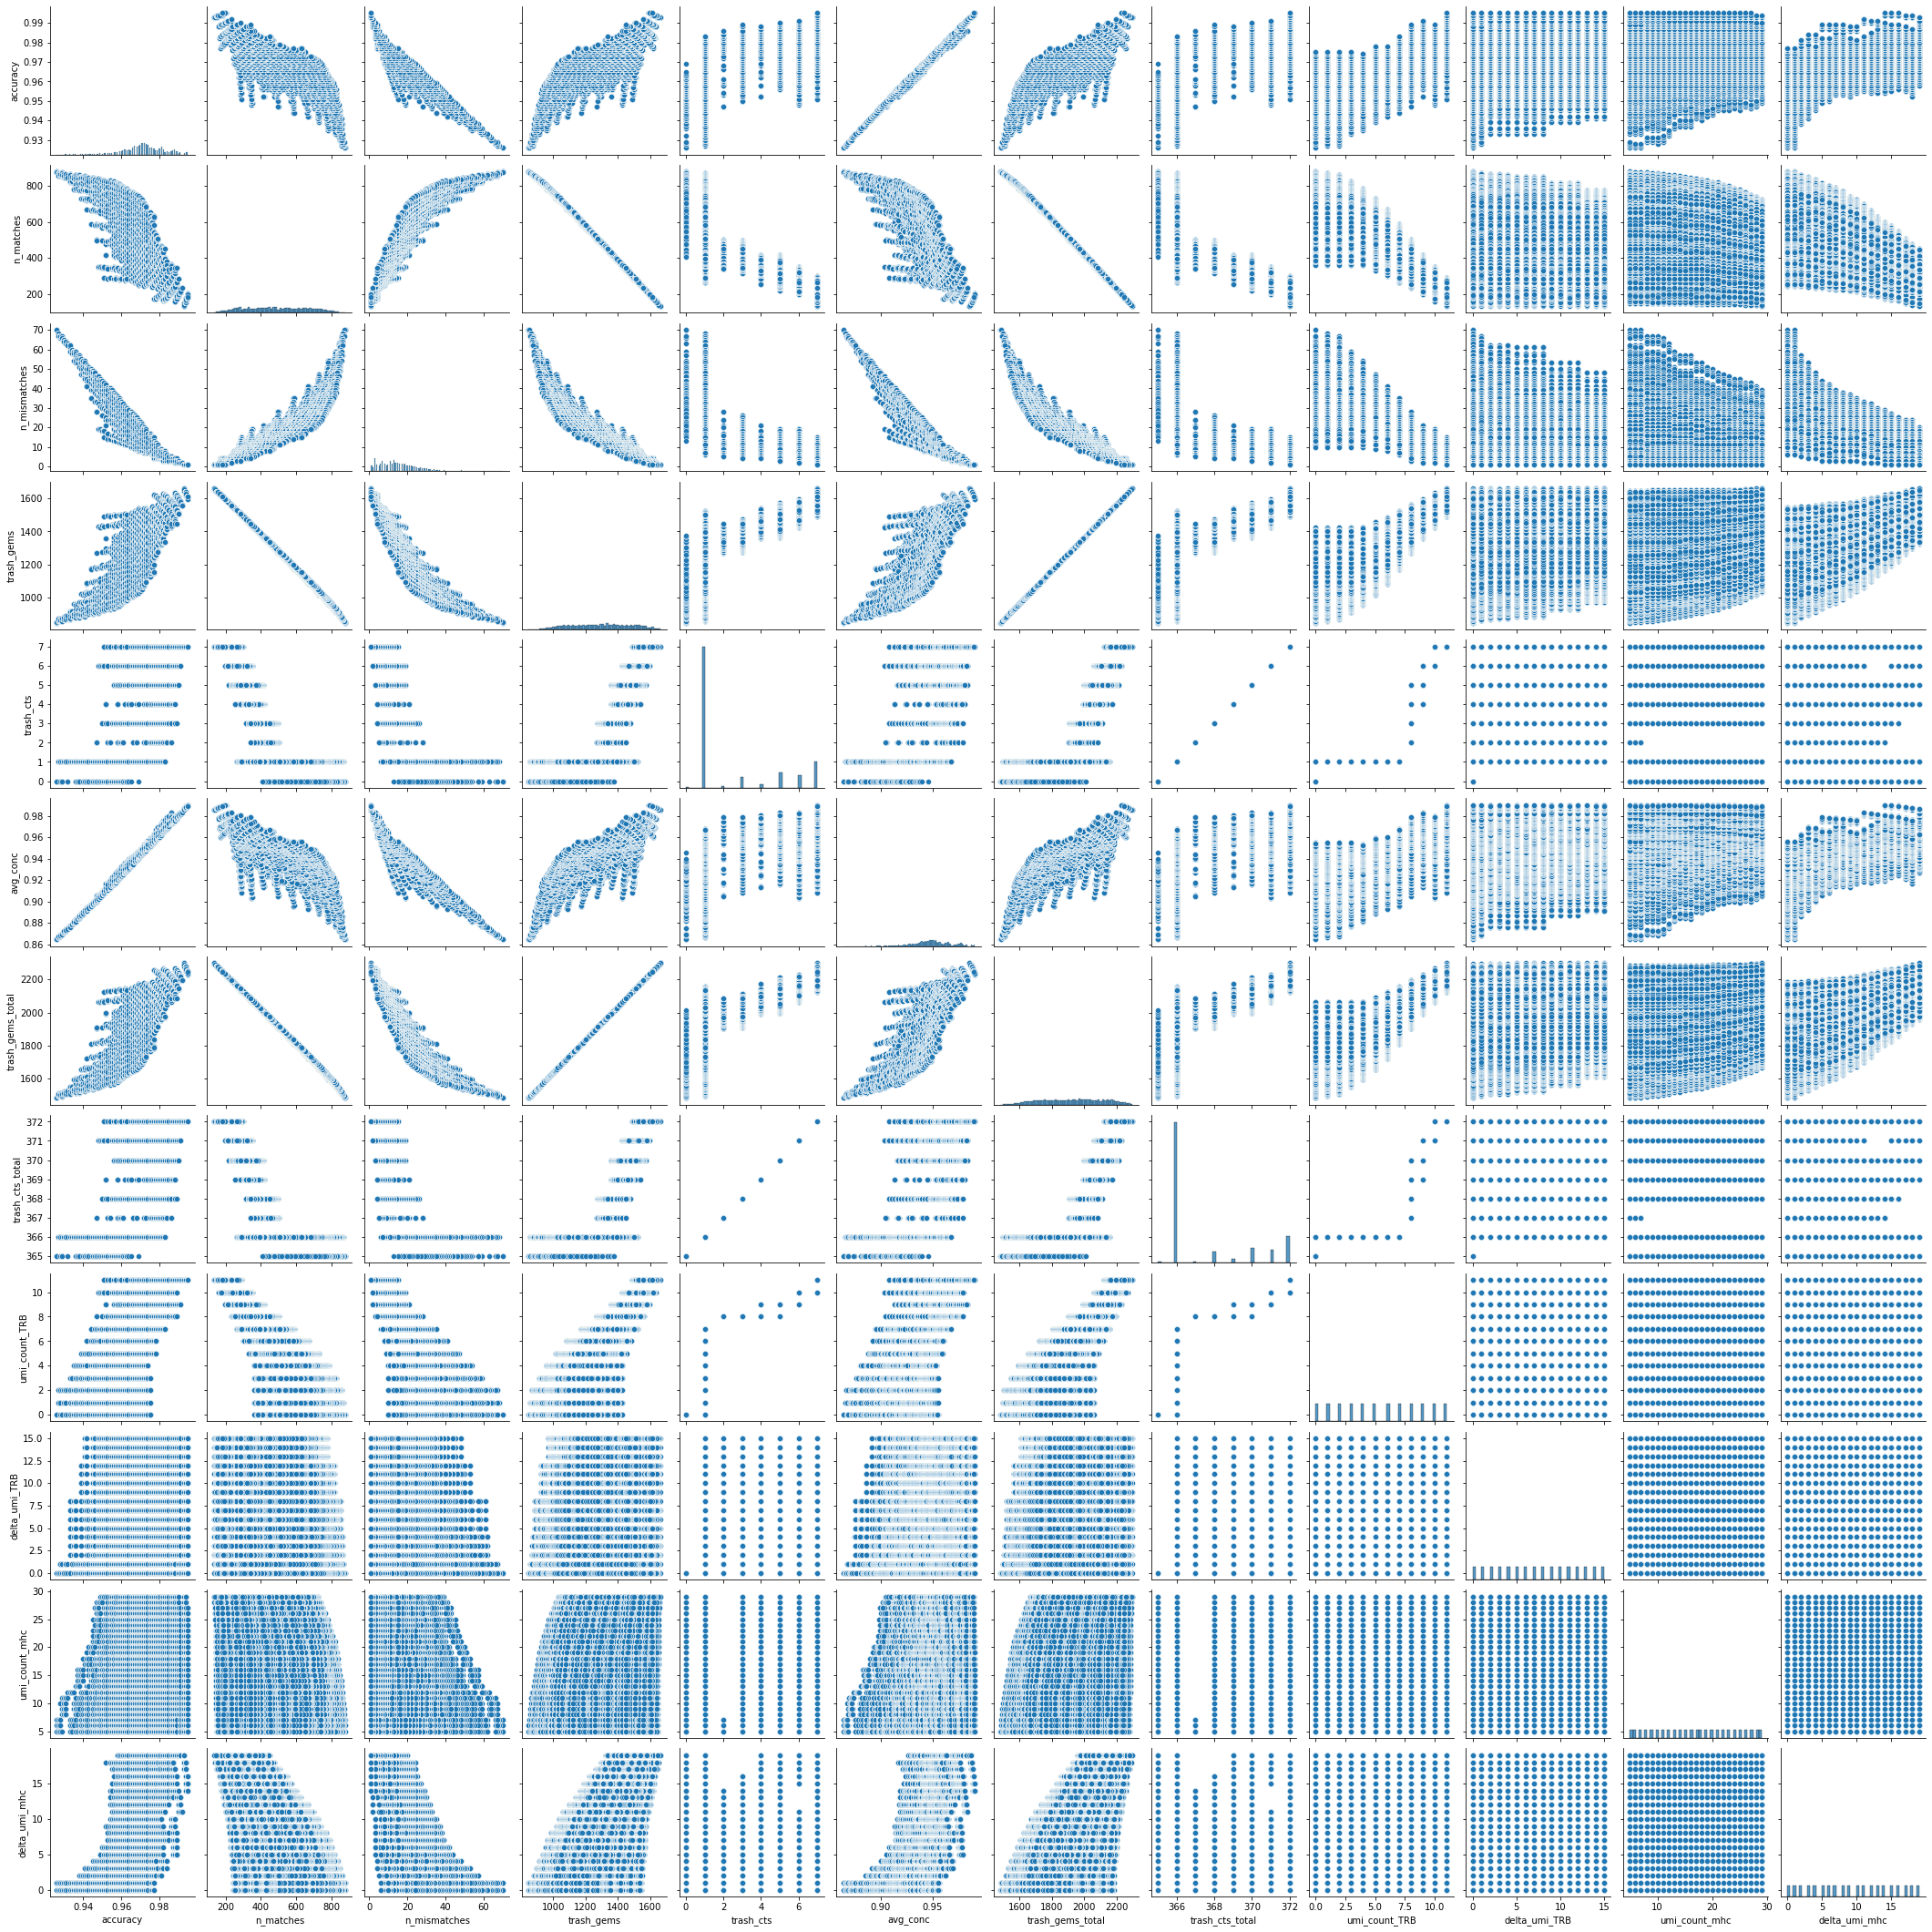

In [16]:
import seaborn as sns
sns.pairplot(table[(table.accuracy < 1) & (table.accuracy > 0.8)])

In [21]:
n = 2
table['mix_mean'] = (table.accuracy * n + table.ratio_retained_gems)/(n+1)
table['mix_mult'] = table.accuracy * table.ratio_retained_gems
#table['mix_mean'] = (table.accuracy * n + table.mix_mult)/(n+1)
table['mix_frac'] = table.accuracy / table.ratio_retained_gems
table['mix_geom'] = (table.accuracy * table.ratio_retained_gems)**(1/2)

In [22]:
# Set index according to sorting so that plot will look nicer
table.sort_values(by=['accuracy','ratio_retained_gems'], inplace=True)
table.reset_index(drop=True, inplace=True)

In [23]:
optimal_thresholds = (table[['accuracy','n_matches','ratio_retained_gems','trash_cts','umi_relat_mhc_l',
                                             'umi_count_mhc','delta_umi_mhc','umi_count_TRB','delta_umi_TRB','umi_count_TRA','delta_umi_TRA','avg_conc','mix_mean']]
                      .sort_values(by=['mix_mean', 'accuracy','ratio_retained_gems', #'n_matches',
                                       'umi_count_mhc', 'delta_umi_mhc','umi_count_TRB','delta_umi_TRB'],
                                   ascending=[True, True, True, False, False, False, False])
                      .tail(20))
#thresholds #'mix_geom', #'umi_relat_mhc_l',
#thresholds
optimal_thresholds

,accuracy,n_matches,ratio_retained_gems,trash_cts,umi_relat_mhc_l,umi_count_mhc,delta_umi_mhc,umi_count_TRB,delta_umi_TRB,umi_count_TRA,delta_umi_TRA,avg_conc,mix_mean
24451,0.959,820.0,0.480,0.0,NaN,13.0,2.0,1.0,1.0,0.0,0.0,0.923295,0.799333
24450,0.959,820.0,0.480,0.0,NaN,13.0,2.0,1.0,0.0,0.0,0.0,0.923295,0.799333
24449,0.959,820.0,0.480,0.0,NaN,13.0,2.0,0.0,4.0,0.0,0.0,0.923295,0.799333
24448,0.959,820.0,0.480,0.0,NaN,13.0,2.0,0.0,3.0,0.0,0.0,0.923295,0.799333
24447,0.959,820.0,0.480,0.0,NaN,13.0,2.0,0.0,2.0,0.0,0.0,0.923295,0.799333
24446,0.959,820.0,0.480,0.0,NaN,13.0,2.0,0.0,1.0,0.0,0.0,0.923295,0.799333
14883,0.951,842.0,0.497,0.0,NaN,8.0,2.0,0.0,0.0,0.0,0.0,0.909274,0.799667
15557,0.952,840.0,0.495,0.0,NaN,9.0,2.0,0.0,0.0,0.0,0.0,0.911150,0.799667
28468,0.961,817.0,0.477,0.0,NaN,14.0,2.0,1.0,4.0,0.0,0.0,0.927185,0.799667
28467,0.961,817.0,0.477,0.0,NaN,14.0,2.0,1.0,3.0,0.0,0.0,0.927185,0.799667


In [24]:
# Get index of optimal threshold
opt_thr_idx = optimal_thresholds.tail(1).index[0]

In [25]:
# Get threshold values
opt_thr = optimal_thresholds.loc[opt_thr_idx, ['umi_count_mhc','delta_umi_mhc',
                                               'umi_count_TRB','delta_umi_TRB',
                                               'umi_count_TRA','delta_umi_TRA']]

In [26]:
# Combine thr to string for output-names: '14.2.0.5.0.0'
thr_name = '.'.join(opt_thr.astype(int).astype(str).values)

In [27]:
# Get bool of dataframe
def get_filtered_data(df, opt_thr=opt_thr):
    def get_var_name(variable):
        # Convert name of variable to string
        for name in globals():
            if variable.equals(eval(name)):
                return name
    df_name = get_var_name(df)
    
    # Convert series of opt_thr to an exacutable and execute
    selection = eval(' & '.join(['(%s.%s >= %d)'%(df_name,k,v) for k,v in opt_thr.to_dict().items()]))
    # Combine thr to string for output-names
    #threshold = '.'.join(opt_thr.astype(int).astype(str).values)
    
    return selection

In [50]:
df.any(axis=1)

0       True
1       True
2       True
3       True
4       True
        ... 
2262    True
2263    True
2264    True
2265    True
2266    True
Length: 2267, dtype: bool

In [27]:
table.sort_values(by=['accuracy','ratio_retained_gems'], inplace=True)
#table.reset_index(drop=True, inplace=True)

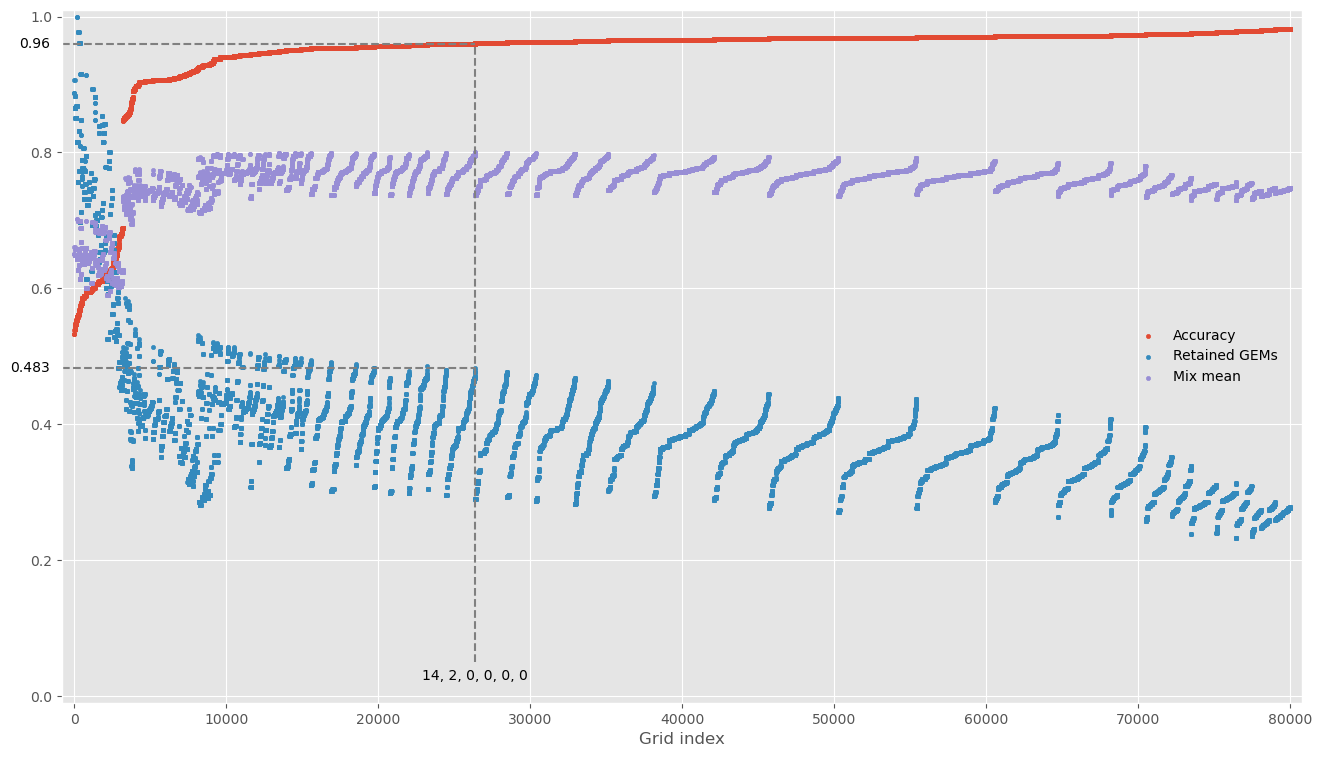

In [35]:
#set_thresh = {'accuracy': 0.8, 'ratio_retained_cts': 0.8, 'ratio_retained_gems': 0.0}
#thresholds = ((table.accuracy < 1) &
#              (table.accuracy > set_thresh['accuracy']) &
#              (table.ratio_retained_cts > set_thresh['ratio_retained_cts']) &
#              (table.ratio_retained_gems > set_thresh['ratio_retained_gems']))

plt_t = table #[thresholds] #.sort_values(by=['accuracy','ratio_retained_gems']).reset_index(drop=True)  #,'ratio_retained_cts'
x_min = plt_t.index.max()*0.01
x_max = plt_t.index.max()

fig = plt.figure(figsize=(16,9))
ax = plt.gca()

import matplotlib.transforms as transforms
trans = transforms.blended_transform_factory(ax.transAxes, ax.transData)

x = plt_t.index
y = plt_t.accuracy
plt.scatter(x,y, label='Accuracy', marker='.')

x = plt_t.index
y = plt_t.ratio_retained_gems
plt.scatter(x,y, label='Retained GEMs', marker='.')

#x = plt_t.index
#y = plt_t.ratio_retained_cts
#plt.scatter(x,y, label='Retained TCRs', marker='.')

x = plt_t.index
y = plt_t.mix_mean
plt.scatter(x,y, label='Mix mean', marker='.')

idx = opt_thr_idx # #25419 #18926 #10071 #57437 #47022 #32926 #17985 ####17073 #42861 #30082 #
acc, rat = table.loc[idx, ['accuracy','ratio_retained_gems']]

plt.hlines(y=[acc, rat], xmin=-x_min, xmax=idx, colors='grey', linestyles='--') #-5000
plt.vlines(x=idx, ymin=0.05, ymax=acc, colors='grey', linestyles='--')

t = ', '.join(table.loc[idx, ['umi_count_mhc','delta_umi_mhc',
                              'umi_count_TRA','delta_umi_TRA',
                              'umi_count_TRB','delta_umi_TRB']].astype(int).astype(str))
plt.text(idx, 0.04, t, ha='center', va='top')
#t = ', '.join(['%s: %.2f' %(k,v) for k,v in set_thresh.items()])
#plt.text(idx, 0.015, t, ha='center', va='top')
plt.text(-0.01, acc, str(acc), ha='right', va='center', transform=trans) #5500, -200
plt.text(-0.01, rat, str(rat), ha='right', va='center', transform=trans)

plt.xlim(-x_min, x_max + x_min)
plt.ylim(-0.01, 1.01)
plt.legend(bbox_to_anchor=(0.99, 0.5), loc='center right', frameon=False)
plt.xlabel('Grid index')
#plt.ylabel('Fraction')

#plt.savefig(PLT + 'overview.%d.png' %idx, bbox_inches='tight')
plt.show()

In [38]:
df.columns

Index(['gem', 'clonotype', 'num_clonotype', 'ct', 'genes_TRA', 'genes_TRB',
       'genes_lst_TRA', 'genes_lst_TRB', 'length_TRA', 'cdr1_TRA', 'cdr2_TRA',
       'cdr3_TRA', 'umi_count_TRA', 'umi_count_lst_TRA', 'delta_umi_TRA',
       'cdr3_lst_TRA', 'chain_count_TRA', 'single_TRA', 'length_TRB',
       'cdr1_TRB', 'cdr2_TRB', 'cdr3_TRB', 'umi_count_TRB',
       'umi_count_lst_TRB', 'delta_umi_TRB', 'cdr3_lst_TRB', 'chain_count_TRB',
       'single_TRB', 'single_chain_only', 'umi_count_tcr', 'cdr3_comb',
       'v_gene_TRA', 'j_gene_TRA', 'v_gene_TRB', 'j_gene_TRB', 'tcr_category',
       'no_filtration', 'exclude_single-chain_TCRs',
       'exclude_ambiguous_and_single-chain_TCRs', 'exclude_ambiguous_TCRs',
       'template_id_mhc', 'template_lst_mhc', 'single_barcode_mhc',
       'umi_count_mhc', 'umi_count_lst_mhc', 'read_count_mhc',
       'read_count_lst_mhc', 'multiplets_mhc', 'delta_umi_mhc',
       'template_id_cd8', 'template_lst_cd8', 'single_barcode_cd8',
       'umi_count_

In [33]:
855/(855+74)

0.9203444564047363

In [30]:
len(df)

2432

In [25]:
len(df.ct.unique()) - 366

22

In [28]:
df[(df.umi_count_TRB >= 7) & (df.delta_umi_TRB >= 3) & (df.umi_count_mhc >= 8) & (df.delta_umi_mhc >= 14)].shape #gem.unique().

(481, 68)

# Plot with selected thresholds

In [28]:
import sys  
sys.path.insert(0, '../scripts')

from D_plot_specificity_matrix_utils import (peptide_per_clonotype_by_gem_size,
                                             multiple_peptides_per_gem_w_filtering,
                                             calc_binding_concordance,
                                             epitope_sorter_index,
                                             peptides_per_gem)

In [29]:
df['epitope_rank'] = epitope_sorter_index(df)

In [26]:
calc_binding_concordance(df[df.ct.isin(valid_df.ct)].copy(), 'ct').binding_concordance.mean()

0.4585305492338943

In [27]:
calc_binding_concordance(df, 'ct').binding_concordance.mean()

0.5228875757709368

### Train set plot

In [32]:
valid_df['epitope_rank'] = epitope_sorter_index(valid_df)
peptide_per_clonotype_by_gem_size(valid_df,
                                  clonotype_fmt='ct',
                                  bc_threshold=0,
                                  tcr_threshold=0,
                                  show=False,
                                  save_tuba=PLT+'specificity.trainset.pdf')

{2, 4, 5, 11, 14, 17, 20, 21, 24, 27, 30, 31, 35, 40, 42, 47, 48, 49, 50, 52, 54, 55, 62, 63, 64, 65, 66, 72, 74, 88, 89, 92, 94, 101, 106, 110, 111, 113, 117, 123, 124, 125, 127, 128, 133, 135, 136, 137, 138, 142, 144, 146, 147, 151, 152, 154, 156, 160, 161, 162, 168, 171, 172, 173, 175, 179, 180, 181, 183, 184, 186, 188, 190, 192, 194, 198, 203, 204, 205, 206, 207, 208, 209, 211, 218, 220, 222, 223, 225, 231, 232, 234, 236, 237, 238, 239, 240, 245, 250, 252, 254, 255, 256, 260, 269, 272, 273, 274, 275, 276, 278, 288, 293, 296, 298, 301, 304, 308, 310, 313, 322, 326, 328, 329, 336, 337, 339, 341, 344, 345, 349, 352, 354, 355, 358, 360, 361, 362, 367, 368, 369, 370, 372, 373, 376, 377, 379, 384, 385, 387, 390, 391, 394, 395, 398, 400, 401, 402, 404, 406, 409, 410, 411, 414, 418, 424, 425, 426, 429, 431, 433, 434, 435, 436, 438, 439, 440, 441, 442, 448, 450, 454, 455, 456, 462, 464, 465, 470, 471, 472, 477, 479, 481, 483, 485, 486, 487, 491, 492, 496, 497, 499, 501, 502, 503, 506, 507, 

### Test

In [31]:
tmp_df = df[~df.ct.isin(valid_df.ct)].copy()
tmp_df['epitope_rank'] = epitope_sorter_index(tmp_df)
peptide_per_clonotype_by_gem_size(tmp_df,
                                  clonotype_fmt='ct',
                                  bc_threshold=0,
                                  tcr_threshold=0,
                                  show=False,
                                  save_tuba=PLT+'specificity.testset.pdf')

{1664, 1793, 514, 1923, 1282, 1030, 2183, 647, 776, 1546, 1031, 1678, 1935, 1041, 275, 1051, 668, 925, 1059, 2170, 1063, 2086, 1830, 42, 2218, 1969, 2104, 1210, 1083, 188, 1722, 702, 1214, 1470, 193, 1986, 1091, 1860, 1862, 1734, 2246, 1100, 1613, 463, 88, 1498, 348, 1500, 2143, 224, 1123, 100, 743, 105, 1771, 1516, 2029, 1775, 1394, 114, 1396, 888, 122, 763, 1916, 509, 1662}


### Train w/ threshold

In [32]:
valid_df['epitope_rank'] = epitope_sorter_index(valid_df)
#tmp = valid_df[(valid_df.umi_count_TRB >= 0) &
#               (valid_df.delta_umi_TRB >= 0) &
#               (valid_df.umi_count_mhc >= 8) &
#               (valid_df.delta_umi_mhc >= 2)].copy() # & (valid_df.umi_count_mhc_rel >= 0.082759)
print(thr_name)
filtering = get_filtered_data(valid_df)
tmp = valid_df[filtering].copy()

print(calc_binding_concordance(tmp, 'ct').binding_concordance.mean())
print(sum(tmp.pep_match) / len(tmp))

peptide_per_clonotype_by_gem_size(tmp,
                                  clonotype_fmt='ct',
                                  bc_threshold=0,
                                  tcr_threshold=0,
                                  show=False,
                                  save_tuba=PLT+'specificity.trainset.thr.%s.pdf' %thr_name)

14.2.0.0.0.0
0.9256960437027563
0.9604651162790697
{768, 142, 785, 660, 1301, 276, 404, 538, 674, 547, 423, 1193, 1580, 1073, 1202, 435, 695, 828, 1725, 1735, 845, 980, 470, 871, 1004, 368, 1652, 1397, 631, 760, 1401, 636, 765, 1663}


### Test w/ threshold

In [31]:
#tmp_df = df[~df.ct.isin(valid_df.ct) &
#            (df.umi_count_TRB >= 0) &
#            (df.delta_umi_TRB >= 0) &
#            (df.umi_count_mhc >= 8) &
#            (df.delta_umi_mhc >= 2)].copy() # & (df.umi_count_mhc_rel >= 0.082759)
print(thr_name)
filtering = get_filtered_data(df)
tmp_df = df[~df.ct.isin(valid_df.ct) & filtering].copy()

tmp_df['epitope_rank'] = epitope_sorter_index(tmp_df)

print(calc_binding_concordance(tmp_df, 'ct').binding_concordance.mean())

peptide_per_clonotype_by_gem_size(tmp_df,
                                  clonotype_fmt='ct',
                                  bc_threshold=0,
                                  tcr_threshold=0,
                                  show=False,
                                  save_tuba=PLT+'specificity.testset.thr.%s.pdf' %thr_name)

14.2.0.0.0.0
0.989010989010989
set()


### Total w/ threshold

In [30]:
#total = df[(df.umi_count_TRB >= 0) &
#           (df.delta_umi_TRB >= 0) &
#           (df.umi_count_mhc >= 8) &
#           (df.delta_umi_mhc >= 2)].copy() # & (df.umi_count_mhc_rel >= 0.082759)
filtering = get_filtered_data(df)
total = df[filtering].copy()
total['epitope_rank'] = epitope_sorter_index(total)
#total = calc_binding_concordance(total, 'ct')
#print(calc_binding_concordance(total, 'ct').binding_concordance.mean())
#print(total.binding_concordance.mean())

peptide_per_clonotype_by_gem_size(total,
                                  clonotype_fmt='ct',
                                  bc_threshold=0,
                                  tcr_threshold=0,
                                  show=False,
                                  save_tuba=PLT+'specificity.total.thr.%s.pdf' %thr_name)

{1054, 544, 2209, 805, 686, 560, 1073, 696, 184, 2111, 840, 1354, 976, 1107, 980, 1237, 2005, 476, 861, 1508, 1639, 1001, 1773, 1263, 1519, 886}


In [31]:
peptide_per_clonotype_by_gem_size(df,
                                  clonotype_fmt='ct',
                                  bc_threshold=0, tcr_threshold=0, show=False, save_tuba='specificity.total.thr.none.pdf')

{2, 2050, 2051, 2053, 6, 5, 2052, 2054, 2056, 2059, 2057, 13, 2062, 2055, 17, 2068, 2069, 20, 2071, 23, 25, 2074, 2075, 2076, 30, 35, 2085, 38, 39, 2086, 2088, 42, 45, 2094, 2095, 2098, 2099, 52, 2101, 2102, 54, 2103, 2104, 60, 61, 62, 2111, 2112, 64, 66, 68, 69, 2116, 2118, 2119, 2123, 2126, 79, 2127, 2129, 82, 83, 84, 2130, 85, 2133, 88, 2139, 94, 2143, 96, 2142, 2146, 2147, 100, 2145, 2151, 105, 2153, 2156, 2160, 2161, 2162, 114, 2164, 118, 119, 2168, 2169, 122, 2170, 124, 2172, 127, 2176, 134, 2183, 2182, 141, 2189, 2191, 2193, 145, 146, 2194, 2197, 150, 2199, 154, 2203, 2202, 161, 2209, 163, 2211, 165, 166, 162, 2210, 2213, 2218, 172, 174, 175, 2224, 2222, 178, 177, 2231, 2232, 184, 186, 2234, 188, 189, 2237, 190, 2240, 193, 197, 198, 2246, 201, 203, 2254, 210, 211, 2260, 214, 2265, 2266, 222, 224, 227, 228, 229, 231, 235, 236, 237, 239, 240, 244, 247, 250, 252, 254, 258, 263, 264, 265, 266, 267, 268, 269, 271, 275, 281, 284, 286, 287, 290, 301, 302, 305, 307, 309, 312, 313, 314, 

In [28]:
peptides_per_gem(df, clonotype_fmt='ct',
                 bc_threshold=0, tcr_threshold=0, show=False, save_tuba='peptide_per_gem.total.thr.none.pdf')

Inside peptides_per_gem


In [31]:
multiple_peptides_per_gem_w_filtering(df, clonotype_fmt='ct',
                                      bc_threshold=0, tcr_threshold=0, show=False, save_tuba='peptide_per_gem.multiple.total.thr.none.pdf')

Inside multiple_peptides_per_gem_w_filtering


In [30]:
#total = df[(df.umi_count_TRB >= 0) &
#           (df.delta_umi_TRB >= 0) &
#           (df.umi_count_mhc >= 8) &
#           (df.delta_umi_mhc >= 2)].copy() # & (df.umi_count_mhc_rel >= 0.082759)
#total['epitope_rank'] = epitope_sorter_index(total)
filtering = get_filtered_data(df)
total = df[filtering].copy()
total['epitope_rank'] = epitope_sorter_index(total)

multiple_peptides_per_gem_w_filtering(total, clonotype_fmt='ct',
                                      bc_threshold=0,
                                      tcr_threshold=0,
                                      threshold=opt_thr,
                                      show=False,
                                      save_tuba=PLT+'peptide_per_gem.multiple.total.thr.%s.pdf' %thr_name)

Inside multiple_peptides_per_gem_w_filtering


In [36]:
pd.Series().empty

/Users/herpov/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


True

### Trash w/ threshold

In [34]:
#trash = df[~((df.umi_count_TRB >= 0) &
#             (df.delta_umi_TRB >= 0) &
#             (df.umi_count_mhc >= 8) &
#             (df.delta_umi_mhc >= 2))].copy()
filtering = get_filtered_data(df)
trash = df[~filtering].copy()
trash['epitope_rank'] = epitope_sorter_index(trash)
trash = calc_binding_concordance(trash, 'ct')
print(calc_binding_concordance(trash, 'ct').binding_concordance.mean())
print(trash.binding_concordance.mean())

peptide_per_clonotype_by_gem_size(trash,
                                  clonotype_fmt='ct',
                                  bc_threshold=0,
                                  tcr_threshold=0,
                                  show=False,
                                  save_tuba=PLT+'specificity.trash.thr.%s.pdf' %thr_name)

0.42862833450581794
0.42862833450581794
{2048, 2, 2051, 2053, 6, 2055, 2056, 2058, 2059, 2061, 13, 2064, 18, 2067, 2070, 23, 25, 2075, 2079, 32, 35, 2083, 37, 2084, 40, 2088, 42, 2091, 2092, 45, 41, 2095, 2102, 55, 2104, 2107, 63, 2111, 2112, 69, 71, 72, 2126, 2128, 82, 2130, 87, 88, 2136, 2143, 2145, 99, 2148, 101, 2150, 103, 2155, 108, 2159, 2162, 117, 2168, 121, 2172, 2173, 127, 2176, 2177, 130, 2178, 133, 137, 2186, 2190, 2192, 2193, 148, 2197, 2198, 149, 154, 2203, 2205, 158, 2207, 164, 165, 167, 2216, 2219, 2220, 2221, 176, 2225, 178, 181, 184, 186, 2234, 2235, 190, 2238, 194, 2243, 2244, 198, 2246, 202, 203, 206, 208, 2257, 2256, 215, 216, 2265, 2267, 2268, 2271, 2273, 227, 2276, 229, 232, 233, 234, 2285, 2287, 240, 242, 2292, 245, 246, 2296, 249, 252, 2303, 257, 2309, 2311, 2312, 2315, 268, 269, 270, 2321, 274, 273, 276, 280, 2329, 282, 2335, 288, 2341, 2342, 297, 308, 314, 319, 320, 321, 322, 327, 335, 337, 340, 342, 357, 361, 362, 367, 369, 371, 373, 386, 394, 399, 400, 404, 

# Similarity

In [20]:
import random
import statistics

In [21]:
def get_unique_entries(df):
    return np.where((df.cdr3_TRA==a) & (df.cdr3_TRB==b), False, True)

def get_sample_size():
    inter_entries = get_unique_entries(inter_chains)
    inter_indexes = inter_chains[inter_entries].index.to_list()
    return min(sum(get_unique_entries(group)), len(inter_indexes))

def add_similarity_scores(ai,bi):
    mat_a = sim_tra.loc[ai, a].reset_index(drop=True).T.reset_index(drop=True).T
    mat_b = sim_trb.loc[bi, b].reset_index(drop=True).T.reset_index(drop=True).T 
    return mat_a.add(mat_b)

def avg_similarity_scores(ai,bi):
    mat_a = sim_tra.loc[ai, a].reset_index(drop=True).T.reset_index(drop=True).T.to_frame().T
    mat_b = sim_trb.loc[bi, b].reset_index(drop=True).T.reset_index(drop=True).T.to_frame().T
    return pd.concat([mat_a, mat_b], ignore_index=True).mean() #.to_frame() is important?

def get_intra_similarity(cdr3_TRAs, cdr3_TRBs, method='sum'):
    unique_entries = get_unique_entries(group)
    unique_entry_indexes = group[unique_entries].index.to_list()

    sample_size = get_sample_size()
    
    #print(sample_size)

    sampled_idxs = random.sample(unique_entry_indexes, sample_size)
    #print(sampled_idxs)
    intra_a = group.loc[sampled_idxs, 'cdr3_TRA'].values
    intra_b = group.loc[sampled_idxs, 'cdr3_TRB'].values
    
    #print(intra_b)
    
    if method == 'sum':
        combined_similarity = add_similarity_scores(intra_a, intra_b)
    else:
        combined_similarity = avg_similarity_scores(intra_a, intra_b)
    return {'score': combined_similarity.max(),
            'fraction': sum(combined_similarity > 1.8)/len(combined_similarity)}

def get_inter_similarity(cdr3_TRAs, cdr3_TRBs, method='sum'):
    # OBS! make sure the size to sample from matches the number og unique entries intra_similarity! 
    unique_entries = get_unique_entries(inter_chains)
    unique_entry_indexes = inter_chains[unique_entries].index.to_list()

    sample_size = get_sample_size()

    sampled_idxs = random.sample(unique_entry_indexes, sample_size)
    inter_a = inter_chains.loc[sampled_idxs, 'cdr3_TRA'].values
    inter_b = inter_chains.loc[sampled_idxs, 'cdr3_TRB'].values
    
    if method == 'sum':
        combined_similarity = add_similarity_scores(inter_a, inter_b)
    else:
        combined_similarity = avg_similarity_scores(inter_a, inter_b)
    return {'score': combined_similarity.max(),
            'fraction': sum(combined_similarity > 1.8)/len(combined_similarity)}

def paired_t_test(x1 ,x2):
    assert len(x1) == len(x2)
    statistic, pvalue = stats.ttest_rel(x1, x2)
    if (pvalue/2.0 < 0.05) & (statistic > 0) & (len(x1) > 9):
        return {'test':True, 'pvalue':pvalue}
    else:
        return {'test':False, 'pvalue':pvalue}

def add_number_of_observations(intra_lst, inter_lst):
    for box, lst in enumerate([intra_lst, inter_lst], start=1):
        if lst:
            median = statistics.median(lst)
            plt.text(box, median, "n: %i" %len(lst), ha='center', va='bottom')

def add_significance_bar(intra_lst, inter_lst):
    t = paired_t_test(intra_lst, inter_lst)#['pvalue']
    if t['test'] and t['pvalue'] < 0.05:
        pass
    else:
        return
    
    y0 =  max(max(intra_lst), max(inter_lst))
    y1 = y0 * 1.02
    y2 = y0 * 1.025
    y3 = y0 * 1.03
    y4 = y0 * 1.035

    plt.plot([1,1,2,2], [y1,y2,y2,y1], lw=1.5, c='k')
    plt.text(1.5, y3, "p = %.6f" %t['pvalue'], ha='center', va='bottom', color='k')
    plt.plot(1, y4)

def plot_boxplot(intra_lst, inter_lst, title='Pooled'):
    plt.figure(figsize=(3,5))
    plt.boxplot([intra_lst, inter_lst], labels=['intra', 'inter'], widths=(0.5, 0.5))
    plt.title(title)
    plt.xlim(0.6, 2.4)
    plt.ylabel("Similarity")
    
    add_number_of_observations(intra_lst, inter_lst)
    add_significance_bar(intra_lst, inter_lst)
    
    #plt.show()

    #plt.savefig(get_file('boxplot'), bbox_inches='tight')
    #plt.cla()   # Clear axis
    #plt.clf()   # Clear figure
    #plt.close()

def plot_pieplot(significant_count, total_peptides):
    plt.pie([significant_count, total_peptides-significant_count],
            labels=['significant', 'insignificant'],
            autopct=lambda p: '{:.0f} ({:.0f}%)'.format(p * total_peptides / 100, p))
    plt.title("Proportion of significant outcomes (%i)" %total_peptides)
    plt.savefig(get_file('pieplot'), bbox_inches='tight')
    plt.cla()   # Clear axis
    plt.clf()   # Clear figure
    plt.close()

In [22]:
sim_tra = sim_tra[~sim_tra.index.duplicated()].copy()
sim_trb = sim_trb[~sim_trb.index.duplicated()].copy()
#sim_tra['None'] = np.nan
#sim_trb['None'] = np.nan
#sim_tra.loc['None',:] = np.nan
#sim_trb.loc['None',:] = np.nan

### Similarity between plateaus on staircase plot for each dataset respectively
similarity is a sum over alpha and beta chains.  Clonotypes with missing chains are excluded. Therefore we can truely trust in high similarities. However, when we have many clonotypes with a missing chain the analysis is limited...

In [83]:
gems = set()

In [53]:
# OBS! rel
#thr = (valid_df.umi_count_TRB >= 0) & (valid_df.delta_umi_TRB >= 1) & (valid_df.umi_count_mhc_rel >= 0.034483) & (valid_df.delta_umi_mhc >= 2)
thr = (valid_df.umi_count_TRB >= 0) & (valid_df.delta_umi_TRB >= 0) & (valid_df.umi_count_mhc >= 14) & (valid_df.delta_umi_mhc >= 2)

In [54]:
valid_df['epitope_rank'] = epitope_sorter_index(valid_df)
train = valid_df[thr & (valid_df.ct != 628)].replace('0','').copy() # OBS OBS OBS! Artificially removed ct 628
train = calc_binding_concordance(train, 'ct')

In [55]:
print(train.shape)
print(len(train.ct.unique()))
print(train.binding_concordance.mean())

(904, 77)
17
0.9013833123476757


In [56]:
train.pep_match.sum() / train.shape[0]

0.9469026548672567

In [139]:
# OBS! rel
#thr = (df.umi_count_TRB >= 1) & (df.delta_umi_TRB >= 6) & (df.umi_count_mhc_rel >= 0.034483) & (df.delta_umi_mhc >= 5)
thr = (df.umi_count_TRB >= 0) & (df.delta_umi_TRB >= 5) & (df.umi_count_mhc >= 14) & (df.delta_umi_mhc >= 2)

In [140]:
test = df[~df.ct.isin(valid_df.ct) & thr].copy()
test['epitope_rank'] = epitope_sorter_index(test)
test = calc_binding_concordance(test, 'ct')

In [141]:
print(len(test.ct.unique()))
print(test.shape[0])
print(test.binding_concordance.mean())

62
101
0.9720972097209721


In [142]:
total = df[thr].copy()
total['epitope_rank'] = epitope_sorter_index(total)
total = calc_binding_concordance(total, 'ct')

In [143]:
print(len(total.ct.unique()))
print(total.shape[0])
print(total.binding_concordance.mean())

80
983
0.9175568284279539


In [144]:
if gems == {}:
    gems = set(total.gem)
else:
    excl = gems - set(total.gem)
    rest = df[df.gem.isin(excl)]
    gems = set(total.gem)

In [145]:
rest[['gem','clonotype','ct','genes_lst_TRA','genes_lst_TRB','umi_count_lst_TRB','peptide_HLA_lst','umi_count_lst_mhc','binding_concordance']]

,gem,clonotype,ct,genes_lst_TRA,genes_lst_TRB,umi_count_lst_TRB,peptide_HLA_lst,umi_count_lst_mhc,binding_concordance
387,ATCATGGCATTCTTAC-1,clonotype26,26.0,['CAARPGAQKLVF;TRAV29/DV5;TRAJ54'],['CASSLERDRPYEQYF;TRBV7-9;TRBJ2-7'],[1],"[RAKFKQLL B0801, SVDIHFDPG A0101, RQAYLTNQY A0...","[1, 1, 1, 31]",0.875000
772,CGAGAAGAGGCATGTG-1,clonotype4,4.0,['CAVTAPAYSGAGSYQLTF;TRAV39;TRAJ28'],['CASSYTPGSTYEQYF;TRBV4-2;TRBJ2-7'],[1],[VTEHDTLLY A0101],[23],0.853107
1662,TATGCCCCACAGCCCA-1,clonotype1,1.0,['CAASQNEKLTF;TRAV21;TRAJ48'],['CASRIGAAGNSPLHF;TRBV27;TRBJ1-6'],[1],"[GPFPGNLV B0702, RAKFKQLL B0801, VTEHDTLLY A01...","[3, 4, 4, 33]",0.241935
1676,TCACAAGTCTGGCGAC-1,clonotype1,1.0,['CAASQNEKLTF;TRAV21;TRAJ48'],['CASRIGAAGNSPLHF;TRBV27;TRBJ1-6'],[1],"[KVPAQRLQEA B0702, YPLVKMRLSV B0702, VTEHDTLLY...","[1, 1, 1, 1, 2, 49]",0.241935
1910,TTAGTTCGTGGCCCTA-1,NaN,571.0,['CAARSGGYQKVTF;TRAV21;TRAJ13' 'CAGCTGTASKLTF;...,['CASSKGPQLSTSGELFF;TRBV9;TRBJ2-2'],[1],"[RAKFKQLL B0801, VTEHDTLLY A0101]","[1, 35]",NaN
1991,AAATGCCCATGACGGA-1,NaN,1.0,NaN,['CASRIGAAGNSPLHF;TRBV27;TRBJ1-6'],[1],"[VIRHKRQSW B0801, RAKFKQLL B0801]","[1, 26]",NaN
2029,AGGCCGTGTTAAGATG-1,NaN,628.0,NaN,['CSARGLGQAKEYGYTF;TRBV20-1;TRBJ1-2'],[1],"[FSAGAFILYN A0101, FSAGAFILYK A0101, TADVDAGSL...","[1, 1, 1, 1, 2, 2, 2, 2, 3, 9, 12, 252]",NaN
2073,CATCAGAAGCGGCTTC-1,NaN,4.0,NaN,['CASSYTPGSTYEQYF;TRBV4-2;TRBJ2-7'],[1],"[GPKPAKPCS B0702, FSAGAFILYN A0101, ATTADVDAGS...","[1, 1, 2, 53]",NaN
2077,CATCGGGCATGGTCTA-1,NaN,1.0,NaN,['CASRIGAAGNSPLHF;TRBV27;TRBJ1-6'],[1],"[EERQAYLTNQY A0101, SAGAFILYK A0101]","[2, 14]",NaN
2087,CCATTCGGTTGCCTCT-1,NaN,20.0,NaN,['CASSFRRGQSSYEQYF;TRBV27;TRBJ2-7'],[1],"[TNQYMQRMASV A2401, FSAGAFILYN A0101, TPRVTGGG...","[1, 1, 1, 1, 2, 53]",NaN


In [157]:
sum(df.peptide_HLA_lst.apply(lambda x: np.unique([s.split(' ')[-1] for s in x]).shape[0]) == 1)

1182

In [48]:
trash = df[~thr].copy()
trash['epitope_rank'] = epitope_sorter_index(trash)
trash = calc_binding_concordance(trash, 'ct')

In [66]:
dataset = 'old.all' #'new.train.14.2.0.5' #
sdf = df.dropna(subset=['cdr3_TRA','cdr3_TRB']).copy()

In [67]:
sdf.replace('0','', inplace=True)

AALPGVPPV A0201


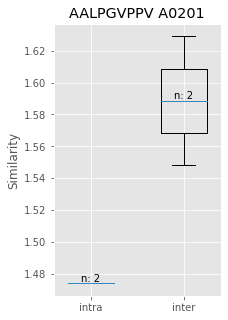

ALPGVPPV A0201


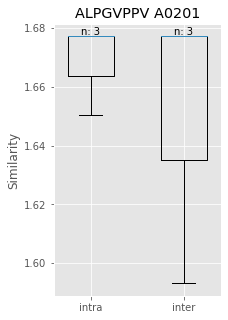

AMLIRDRL B0801


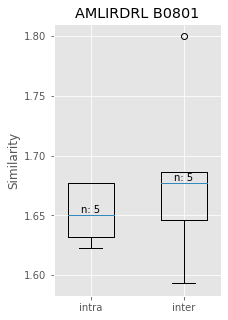

ATTADVDAGSL A0101


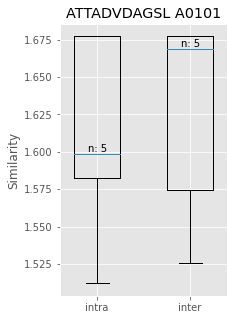

AYLTNQYM A2401


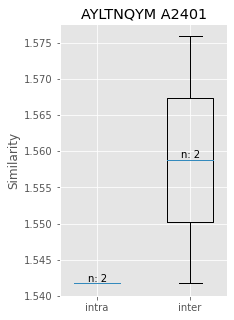

CSSVDIHF A0101


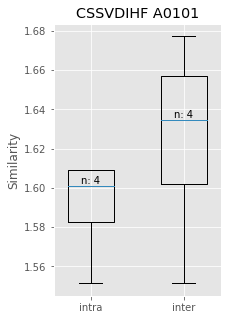

DEYVHNTTA B0801


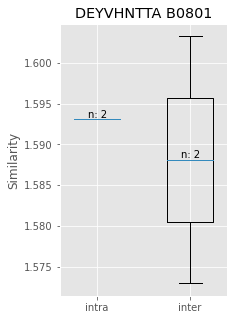

EERQAYLTNQY A0101


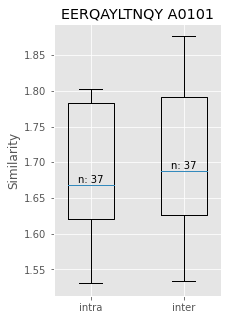

FLDTNQVV A0201


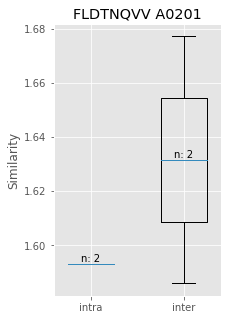

FLDTNQVVRI A0201


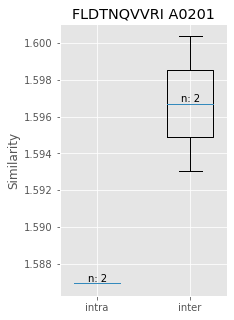

FLVNTMCLAL A0201


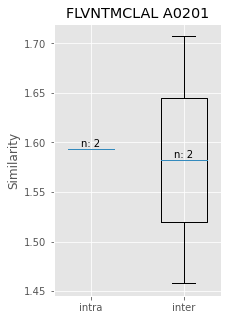

FSAGAFILYK A0101


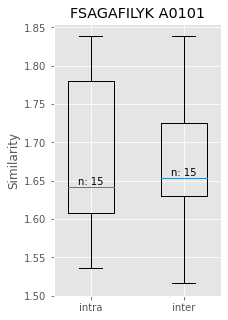

FSAGAFILYN A0101
GLFSAGAFIL A2401


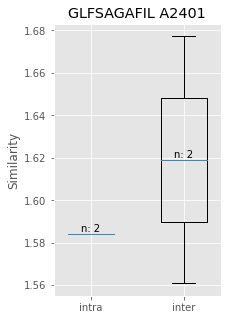

GMAEGATTA A0101


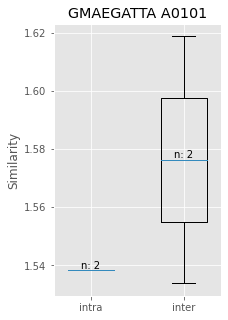

GPFPGNLVD B0702


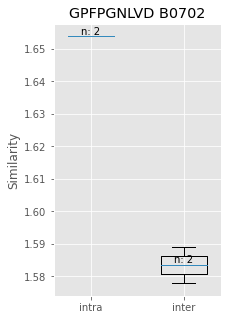

GPFPGNLVDV B0702


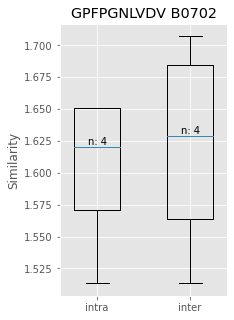

GPKPAKPCSGA B0702
GPRSERRKW B0702
HTGEKHYAC B0801


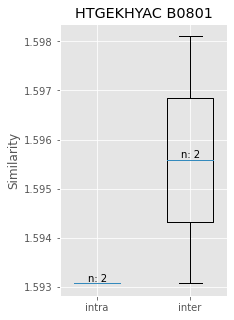

ICSSVDIHF A0101


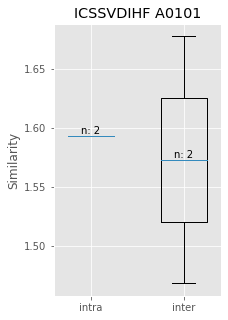

IGLFSAGAFI A2401
IHFDPGFEEQ A0101


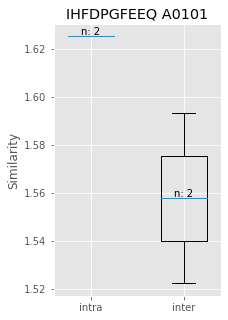

IHFDPGFEEQL A2401
ILKEPVHGV A0201


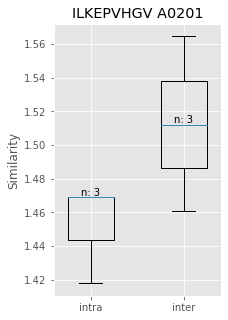

ILLFERPHTM B0801
IRHKRQSW B0801


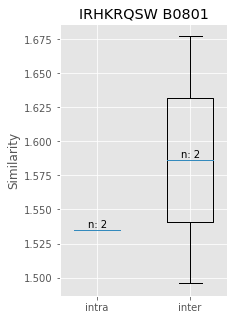

IRHKRQSWV B0801


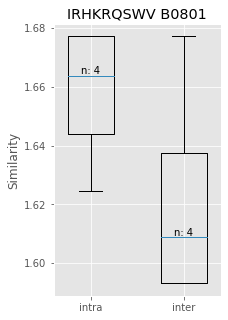

KVPAQRLQEA B0702
LFSAGAFI A2401
LFSAGAFILYN A0101


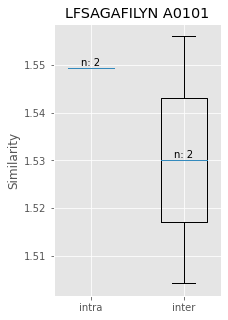

LTNQYMQRM A0101
NLVPMVATV A0201


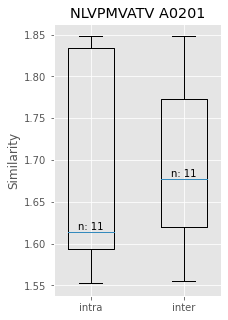

PSTPLKPL B0702
QAYLTNQY A0101


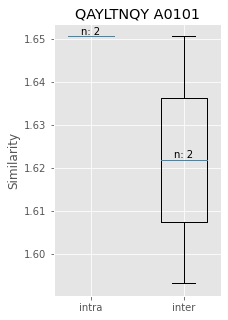

RAKFKQLL B0801


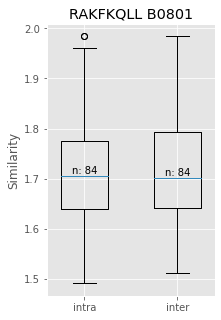

RQAYLTNQY A0101


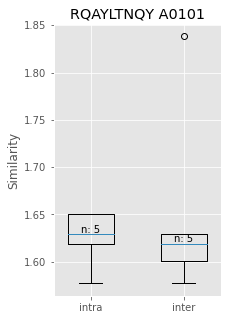

RRKVPAQRL B0801


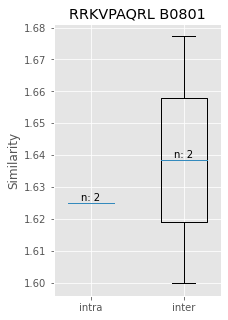

RTMFWGPEV A0201


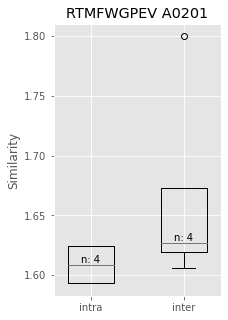

SAGAFILYK A0101


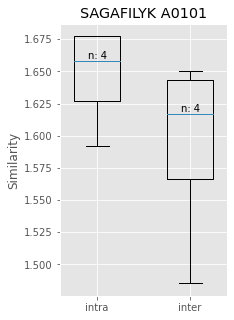

SIKDGLPPV A0201
SLIIQFTSFV A0201


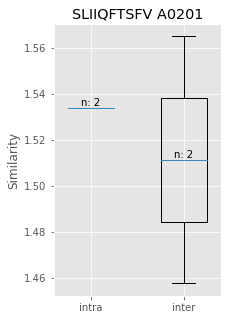

SQKVLRHM B0801


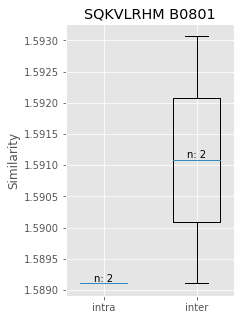

SQSDQTSEL B0801
SSGYRIGQF B0801
SSTEALISV A0201


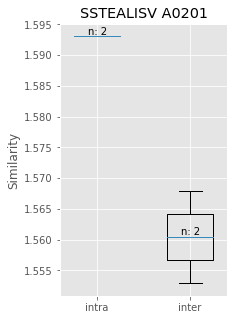

SVDIHFDPG A0101


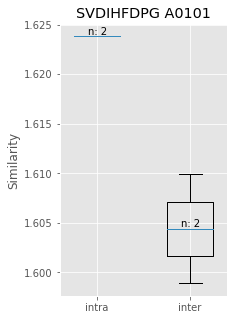

SVDIHFDPGF A0101


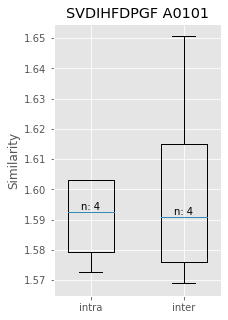

TADVDAGSLS A0101


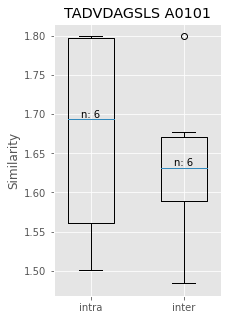

TKFIQTITL B0801
TNQYMQRMASV A2401


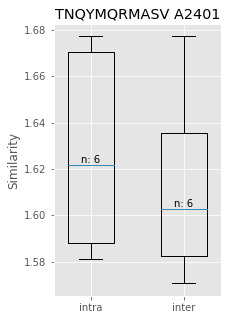

TPRVTGGGAM B0702


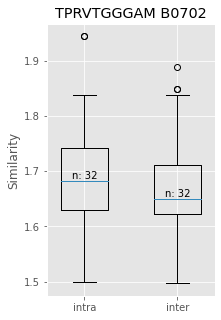

VIRHKRQSW B0801
VPAQRLQEA B0801
VTEHDTLLY A0101


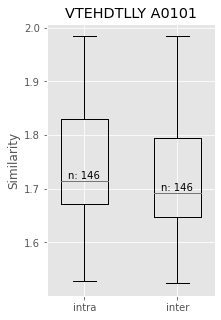

WPRAPRGQ B0702


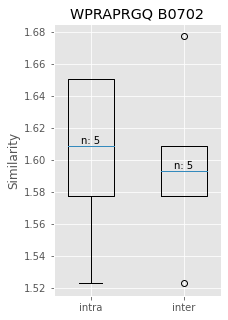

YLFHKEPTW A0201
YLFHKEPTWES A0201
YPLVKMRL B0801
YPLVKMRLSV B0702


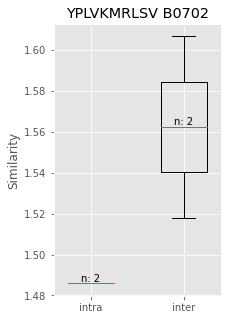

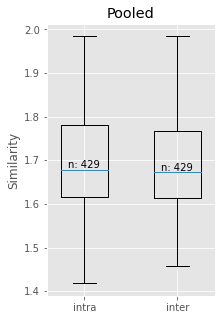

In [68]:
intra_score = list()
inter_score = list()
significant_simulations = list()
n_simulations = 10

#for simulation in range(n_simulations):
for peptide, group in sdf.groupby('peptide_HLA'):
    print(peptide)
    if len(group) == 1:
        continue
    if len(group.drop_duplicates(['cdr3_TRA','cdr3_TRB'])) == 1:
        continue

    inter_chains = sdf.loc[sdf.peptide_HLA != peptide, ['cdr3_TRA', 'cdr3_TRB']]

    intra_score_peptide = list()
    inter_score_peptide = list()  

    # OBS! Maybe get the pairs directly instead of zipping them? Make sure you get true pairs and not just random pairs?!
    cdr3_TRAs = group.drop_duplicates(subset=['cdr3_TRA','cdr3_TRB']).cdr3_TRA.values
    cdr3_TRBs = group.drop_duplicates(subset=['cdr3_TRA','cdr3_TRB']).cdr3_TRB.values
    
    assert len(cdr3_TRAs) == len(cdr3_TRBs) == len(group.loc[:,['cdr3_TRA','cdr3_TRB']].drop_duplicates())
    
    #print(group.loc[:,['cdr3_TRA','cdr3_TRB']].drop_duplicates())

    for index, (a,b) in enumerate(zip(cdr3_TRAs, cdr3_TRBs)):
        intra = get_intra_similarity(cdr3_TRAs, cdr3_TRBs)
        inter = get_inter_similarity(cdr3_TRAs, cdr3_TRBs)

        intra_score_peptide.append(intra['score'])
        inter_score_peptide.append(inter['score'])

        intra_score.append(intra['score'])
        inter_score.append(inter['score'])
      
    
    
    tnobs = len(intra_score_peptide)
    ass = random.sample(intra_score_peptide, tnobs)
    ess = random.sample(inter_score_peptide, tnobs)
    plot_boxplot(ass, ess, title=peptide)
    #plt.savefig('tcr_similarity.%s.%s.pdf'%(dataset,peptide))
    plt.show()


tnobs = len(intra_score)
intra_score = random.sample(intra_score, tnobs)
inter_score = random.sample(inter_score, tnobs)
plot_boxplot(intra_score, inter_score)
plt.savefig('tcr_similarity.pooled.%s.pdf'%dataset)

In [67]:
inter_chains.cdr3_TRA.isin(['']).any()

True

In [77]:
sim_tra.loc[''] = 0

In [79]:
sim_tra[''] = 0

In [80]:
sim_tra

,CAAADSSNDYKLSF,CAAAETSYDKVIF,CAADSMDSNYQLIW,CAADTGGFKTIF,CAADVTDSWGKFQF,CAAEARDNYGQNFVF,CAAENQGGKLIF,CAAFFGNEKLTF,CAAFRAYNTDKLIF,CAAFTGTASKLTF,...,CVVTLHRDDKIIF,CVVTLPTGFQKLVF,CVVTPSNDYKLSF,CVVVIVYQLIW,CVVYAAFYDYKLSF,CWAGSGGGADGLTF,CWAMYSGGGADGLTF,CYGGGYGQNFVF,None,
CAAADSSNDYKLSF,1.000000,0.850811,0.838864,0.795478,0.794966,0.794007,0.792768,0.782006,0.802472,0.806024,...,0.755261,0.732881,0.853085,0.657962,0.767848,0.718508,0.719988,0.705542,NaN,0
CAAAETSYDKVIF,0.850811,1.000000,0.816523,0.825797,0.796728,0.786828,0.816777,0.800367,0.827563,0.837818,...,0.796047,0.785194,0.809807,0.732118,0.783453,0.710259,0.720886,0.717878,NaN,0
CAADSMDSNYQLIW,0.838864,0.816523,1.000000,0.776601,0.786641,0.782113,0.779289,0.765487,0.782802,0.776356,...,0.757377,0.743537,0.792252,0.708134,0.740843,0.688113,0.702256,0.701974,NaN,0
CAADTGGFKTIF,0.795478,0.825797,0.776602,1.000000,0.790774,0.760217,0.846023,0.815959,0.783972,0.843036,...,0.749168,0.785064,0.776810,0.699353,0.737437,0.784161,0.766879,0.776085,NaN,0
CAADVTDSWGKFQF,0.794966,0.796728,0.786641,0.790775,1.000000,0.764450,0.770901,0.757278,0.758581,0.786179,...,0.734076,0.743704,0.766880,0.679265,0.725531,0.703444,0.711522,0.702242,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CWAGSGGGADGLTF,0.718508,0.710259,0.688113,0.784161,0.703444,0.692823,0.769762,0.725267,0.689002,0.766475,...,0.640685,0.675090,0.674280,0.577435,0.637567,1.000000,0.861253,0.770739,NaN,0
CWAMYSGGGADGLTF,0.719988,0.720886,0.702256,0.766880,0.711522,0.701939,0.759204,0.737462,0.715839,0.766954,...,0.667169,0.699328,0.693435,0.615877,0.683873,0.861253,1.000000,0.751892,NaN,0
CYGGGYGQNFVF,0.705542,0.717878,0.701974,0.776085,0.702242,0.754217,0.772544,0.761587,0.714960,0.737668,...,0.671264,0.702625,0.700840,0.643563,0.704403,0.770739,0.751892,1.000000,NaN,0
None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [70]:
group

,Unnamed: 0,gem,clonotype,num_clonotype,ct,genes_TRA,genes_TRB,genes_lst_TRA,genes_lst_TRB,length_TRA,...,peptide_HLA,peptide_HLA_lst,epitope,epitope_lst,gems_per_specificity,gems_per_clonotype,binding_concordance,ct_pep,pep_match,epitope_rank
337,442,ATGTGTGGTTGCGTTA-1,clonotype4,4.0,6.0,TRAV39;TRAJ28;TRAC,TRBV4-2;;TRBJ2-7;TRBC2,['TRAV39;TRAJ28;TRAC'],['TRBV4-2;;TRBJ2-7;TRBC2'],528.0,...,EERQAYLTNQY A0101,"[FSAGAFILYK A0101, CSSVDIHF A0101, GMAEGATTA A...",45_1_3,['45_1_4' '45_1_2' '45_1_37' 'V17_B8 EBV BZLF1...,1,83,0.012048,VTEHDTLLY A0101,False,NaN
576,749,CCTCAGTCATGTTGAC-1,clonotype5,5.0,14.0,TRAV2;TRAJ43;TRAC,TRBV20-1;;TRBJ1-2;TRBC1,['TRAV2;TRAJ43;TRAC'],['TRBV20-1;;TRBJ1-2;TRBC1'],449.0,...,EERQAYLTNQY A0101,"[VTEHDTLLY A0101, FSAGAFILYK A0101, RAKFKQLL B...",45_1_3,['V15_A1 CMV pp50 VTE' '45_1_4' 'V17_B8 EBV...,1,19,0.052632,VTEHDTLLY A0101,False,NaN
636,827,CGATGTAGTACTCAAC-1,clonotype1,1.0,1.0,TRAV21;TRAJ48;TRAC,TRBV27;;TRBJ1-6;TRBC1,['TRAV21;TRAJ48;TRAC'],['TRBV27;;TRBJ1-6;TRBC1'],514.0,...,EERQAYLTNQY A0101,[EERQAYLTNQY A0101],45_1_3,['45_1_3'],1,88,0.011364,TPRVTGGGAM B0702,False,NaN
699,906,CGGTTAATCACTATTC-1,clonotype5,5.0,11.0,TRAV29/DV5;TRAJ34;TRAC,TRBV20-1;;TRBJ1-2;TRBC1,['TRAV29/DV5;TRAJ34;TRAC'],['TRBV20-1;;TRBJ1-2;TRBC1'],539.0,...,EERQAYLTNQY A0101,"[SAGAFILYK A0101, VTEHDTLLY A0101, EERQAYLTNQY...",45_1_3,['45_1_27' 'V15_A1 CMV pp50 VTE' '45_1_3'],3,40,0.075000,VTEHDTLLY A0101,False,NaN
794,1026,CTCGAGGTCAACGGCC-1,clonotype5,5.0,11.0,TRAV29/DV5;TRAJ34;TRAC,TRBV20-1;;TRBJ1-2;TRBC1,['TRAV29/DV5;TRAJ34;TRAC'],['TRBV20-1;;TRBJ1-2;TRBC1'],514.0,...,EERQAYLTNQY A0101,"[SAGAFILYK A0101, VTEHDTLLY A0101, EERQAYLTNQY...",45_1_3,['45_1_27' 'V15_A1 CMV pp50 VTE' '45_1_3'],3,40,0.075000,VTEHDTLLY A0101,False,NaN
1279,1631,TAAACCGAGCACCGTC-1,clonotype5,5.0,11.0,TRAV29/DV5;TRAJ34;TRAC,TRBV20-1;;TRBJ1-2;TRBC1,['TRAV29/DV5;TRAJ34;TRAC'],['TRBV20-1;;TRBJ1-2;TRBC1'],508.0,...,EERQAYLTNQY A0101,"[FSAGAFILYN A0101, AYLTNQYM A2401, RAKFKQLL B0...",45_1_3,['45_1_5' '45_1_63' 'V17_B8 EBV BZLF1 (C9)' 'V...,3,40,0.075000,VTEHDTLLY A0101,False,NaN
1641,2119,AGGGTGACACAGACTT-1,clonotype5,5.0,16.0,,TRBV20-1;;TRBJ1-2;TRBC1,,['TRBV20-1;;TRBJ1-2;TRBC1'],0.0,...,EERQAYLTNQY A0101,"[LFSAGAFIL A0101, ATTADVDAGSL A0101, FSAGAFILY...",45_1_3,['45_1_39' '45_1_1' '45_1_4' '45_1_3'],1,19,0.052632,VTEHDTLLY A0101,False,NaN
1675,2189,CCTCTGACACGGTAGA-1,clonotype4,4.0,7.0,,TRBV4-2;;TRBJ2-7;TRBC2,,['TRBV4-2;;TRBJ2-7;TRBC2'],0.0,...,EERQAYLTNQY A0101,"[LFSAGAFIL A0101, ATTADVDAGSL A0101, FSAGAFILY...",45_1_3,['45_1_39' '45_1_1' '45_1_4' 'V17_B8 EBV BZLF1...,2,68,0.029412,VTEHDTLLY A0101,False,NaN
1689,2212,CGGTTAAAGGGTCGAT-1,clonotype4,4.0,7.0,,TRBV4-2;;TRBJ2-7;TRBC2,,['TRBV4-2;;TRBJ2-7;TRBC2'],0.0,...,EERQAYLTNQY A0101,"[VTEHDTLLY A0101, FSAGAFILYK A0101, RAKFKQLL B...",45_1_3,['V15_A1 CMV pp50 VTE' '45_1_4' 'V17_B8 EBV...,2,68,0.029412,VTEHDTLLY A0101,False,NaN
1751,2346,GTTTCTACACTGTTAG-1,,0.0,32.0,,TRBV19;;TRBJ2-2;TRBC2,,['TRBV19;;TRBJ2-2;TRBC2'],0.0,...,EERQAYLTNQY A0101,"[TPRVTGGGAM B0702, LFSAGAFILYK A0101, LFSAGAFI...",45_1_3,['V14_B7 CMV pp65 TPR' '45_1_7' '45_1_39' '...,1,12,0.083333,VTEHDTLLY A0101,False,NaN


## Alternative: similarity score as a mean
Something's rotten! The sampled indexes for intra test are outside of the group! Why? Also, should I eliminate TCRs that share a single chain? The problem arises when e.g. alpha is NaN and beta exist in multiple combinations with other alphas. Then we get a similarity at 1, because the average is only computed over the beta...

ALPGVPPV A0201
         cdr3_TRA         cdr3_TRB
1162  CAVNYGNKLVF  CASSLVAGAPSEQYF
2408         None  CASSGSDRGGYGYTF
1
[2408]
['CASSGSDRGGYGYTF']
1
[1162]
['CASSLVAGAPSEQYF']
DEYVHNTTA B0801
EERQAYLTNQY A0101
                cdr3_TRA          cdr3_TRB
442   CAVTAPAYSGAGSYQLTF   CASSYTPGSTYEQYF
749        CAVEDRLDNDMRF  CSARGLGQAKEYGYTF
827          CAASQNEKLTF   CASRIGAAGNSPLHF
906       CAAFRAYNTDKLIF  CSARGLGQAKEYGYTF
2154                None  CASSLEAGQKPYEQYF
2189                None   CASSYTPGSTYEQYF
2302                None   CASSLATGRTYGYTF
2346                None  CASRVQFGVNTGELFF
2402                None  CASSFRRGQSSYEQYF
11
[2154, 2402, 749, 2302, 2346, 906, 827, 2212, 1631, 2189, 1026]
['CASSLEAGQKPYEQYF' 'CASSFRRGQSSYEQYF' 'CSARGLGQAKEYGYTF'
 'CASSLATGRTYGYTF' 'CASRVQFGVNTGELFF' 'CSARGLGQAKEYGYTF' 'CASRIGAAGNSPLHF'
 'CASSYTPGSTYEQYF' 'CSARGLGQAKEYGYTF' 'CASSYTPGSTYEQYF' 'CSARGLGQAKEYGYTF']
CAVTAPAYSGAGSYQLTF CASSYTPGSTYEQYF
{'score': 1.0, 'fraction': 0.0}
11
[442, 827, 2

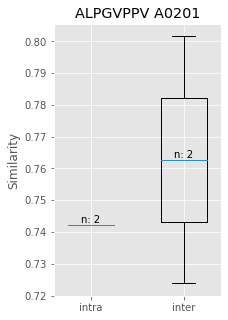

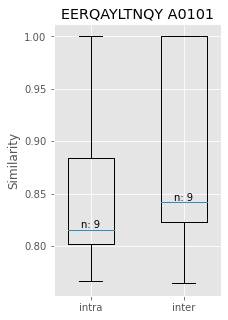

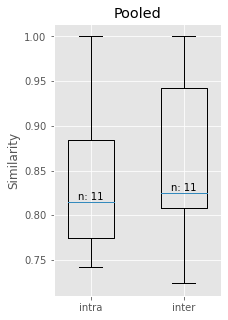

In [197]:
intra_score = list()
inter_score = list()
significant_simulations = list()
n_simulations = 10

#for simulation in range(n_simulations):
for peptide, group in total.fillna('None').groupby('peptide_HLA'):
    print(peptide)
    if len(group) == 1:
        continue
    if len(group.drop_duplicates(['cdr3_TRA','cdr3_TRB'])) == 1:
        continue

    inter_chains = total.loc[total.peptide_HLA != peptide, ['cdr3_TRA', 'cdr3_TRB']].fillna('None')

    intra_score_peptide = list()
    inter_score_peptide = list()  

    # OBS! Maybe get the pairs directly instead of zipping them? Make sure you get true pairs and not just random pairs?!
    cdr3_TRAs = group.drop_duplicates(subset=['cdr3_TRA','cdr3_TRB']).fillna('None').cdr3_TRA.values
    cdr3_TRBs = group.drop_duplicates(subset=['cdr3_TRA','cdr3_TRB']).fillna('None').cdr3_TRB.values
    
    assert len(cdr3_TRAs) == len(cdr3_TRBs) == len(group.loc[:,['cdr3_TRA','cdr3_TRB']].drop_duplicates())
    
    print(group.loc[:,['cdr3_TRA','cdr3_TRB']].drop_duplicates())

    for index, (a,b) in enumerate(zip(cdr3_TRAs, cdr3_TRBs)):
        intra = get_intra_similarity(cdr3_TRAs, cdr3_TRBs, method='mean')
        inter = get_inter_similarity(cdr3_TRAs, cdr3_TRBs, method='mean')
        
        if peptide == 'EERQAYLTNQY A0101':
            print(a,b)
            print(intra)

        intra_score_peptide.append(intra['score'])
        inter_score_peptide.append(inter['score'])

        intra_score.append(intra['score'])
        inter_score.append(inter['score'])
    
    tnobs = len(intra_score_peptide)
    ass = random.sample(intra_score_peptide, tnobs)
    ess = random.sample(inter_score_peptide, tnobs)
    plot_boxplot(ass, ess, title=peptide)
    #plt.savefig('tcr_similarity.%s.%s.pdf'%(dataset,peptide))
    
    if peptide == 'EERQAYLTNQY A0101':
        break


tnobs = len(intra_score)
intra_score = random.sample(intra_score, tnobs)
inter_score = random.sample(inter_score, tnobs)
plot_boxplot(intra_score, inter_score)
#plt.savefig('tcr_similarity.%s.pooled.pdf'%dataset)

In [192]:
#mat_a = sim_tra.loc[ai, a].reset_index(drop=True).T.reset_index(drop=True).T
mat_a = sim_trb.loc['CASSLATGRTYGYTF',['CASRVQFGVNTGELFF','CSARGLGQAKEYGYTF','CASSLEAGQKPYEQYF','CSARGLGQAKEYGYTF','CSARGLGQAKEYGYTF','CASSLATGRTYGYTF','CASSYTPGSTYEQYF',
 'CASRIGAAGNSPLHF', 'CASSYTPGSTYEQYF','CASSFRRGQSSYEQYF', 'CSARGLGQAKEYGYTF']]#.reset_index(drop=True).T.reset_index(drop=True).T 
mat_b = sim_trb.loc[['CASRVQFGVNTGELFF','CSARGLGQAKEYGYTF','CASSLEAGQKPYEQYF','CSARGLGQAKEYGYTF','CSARGLGQAKEYGYTF','CASSLATGRTYGYTF','CASSYTPGSTYEQYF',
 'CASRIGAAGNSPLHF', 'CASSYTPGSTYEQYF','CASSFRRGQSSYEQYF', 'CSARGLGQAKEYGYTF'],'CASSYTPGSTYEQYF'].reset_index(drop=True).T.reset_index(drop=True).T 

In [189]:
pd.concat([mat_a.to_frame().T, mat_b.to_frame().T],ignore_index=False)

,0,1,2,3,4,5,6,7,8,9,10
CASSLATGRTYGYTF,0.767171,0.798432,0.760937,0.798432,0.798432,1.000000,0.801887,0.774039,0.801887,0.761165,0.798432
CASSYTPGSTYEQYF,0.733921,0.735399,0.776191,0.735399,0.735399,0.801887,1.000000,0.743322,1.000000,0.789147,0.735399


In [193]:
mat_a#.to_frame().T

CASRVQFGVNTGELFF    0.767171
CSARGLGQAKEYGYTF    0.798432
CASSLEAGQKPYEQYF    0.760937
CSARGLGQAKEYGYTF    0.798432
CSARGLGQAKEYGYTF    0.798432
CASSLATGRTYGYTF     1.000000
CASSYTPGSTYEQYF     0.801887
CASRIGAAGNSPLHF     0.774039
CASSYTPGSTYEQYF     0.801887
CASSFRRGQSSYEQYF    0.761165
CSARGLGQAKEYGYTF    0.798432
Name: CASSLATGRTYGYTF, dtype: float64

In [157]:
group.loc[np.where((group.cdr3_TRA=='None') & (group.cdr3_TRB=='CASSYTPGSTYEQYF'), False, True), ['cdr3_TRA','cdr3_TRB']]

,cdr3_TRA,cdr3_TRB
442,CAVTAPAYSGAGSYQLTF,CASSYTPGSTYEQYF
749,CAVEDRLDNDMRF,CSARGLGQAKEYGYTF
827,CAASQNEKLTF,CASRIGAAGNSPLHF
906,CAAFRAYNTDKLIF,CSARGLGQAKEYGYTF
1026,CAAFRAYNTDKLIF,CSARGLGQAKEYGYTF
1631,CAAFRAYNTDKLIF,CSARGLGQAKEYGYTF
2154,None,CASSLEAGQKPYEQYF
2302,None,CASSLATGRTYGYTF
2346,None,CASRVQFGVNTGELFF
2402,None,CASSFRRGQSSYEQYF


In [117]:
sim_tra.loc[]

,cdr3_TRA,cdr3_TRB
0,CALRDMEYGNKLVF,CASSLIVSGGANEQFF
6,CALRDMEYGNKLVF,CASSLIVSGGANEQFF
7,CAVNYGNKLVF,CASSLIVSGGANEQFF
11,CALRDMEYGNKLVF,CASSLIVSGGANEQFF
14,CAARPGAQKLVF,CASSLEAGQKPYEQYF
...,...,...
2421,None,CASRVQFGVNTGELFF
2423,None,CASSVGSGSSYEQYF
2425,None,CASSVGSGSSYEQYF
2429,None,CASRVQFGVNTGELFF


In [104]:
cdr3_TRAs

array(['CAVNYGNKLVF', 'None'], dtype=object)

In [107]:
sim_tra.loc[cdr3_TRAs, cdr3_TRAs]

,CAVNYGNKLVF,None
CAVNYGNKLVF,1.0,NaN
None,NaN,NaN


In [113]:
a

'CAVNYGNKLVF'

### ANOVA test of clonotypes 

In [28]:
set(total.ct).intersection(set(trash.ct))

{1.0,
 2.0,
 3.0,
 4.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 13.0,
 14.0,
 16.0,
 17.0,
 18.0,
 20.0,
 21.0,
 22.0,
 24.0,
 25.0,
 27.0,
 28.0,
 29.0,
 33.0,
 35.0,
 36.0,
 37.0,
 39.0,
 40.0,
 41.0,
 42.0,
 45.0,
 46.0,
 47.0,
 48.0,
 49.0,
 51.0,
 60.0,
 62.0,
 63.0,
 67.0,
 69.0,
 74.0,
 75.0,
 80.0,
 92.0,
 98.0,
 103.0,
 114.0,
 118.0,
 120.0,
 131.0,
 136.0,
 147.0}

In [120]:
clonotype = 18 # set(total.ct).intersection(set(trash.ct))
peptides = list(set(df[df.ct == clonotype].peptide_HLA).intersection(total.peptide_HLA))
cdr3_TRA = total[total.ct == clonotype].cdr3_TRA.drop_duplicates().fillna('None')
cdr3_TRB = total[total.ct == clonotype].cdr3_TRB.drop_duplicates().fillna('None')

In [121]:
peptides

['RAKFKQLL B0801', 'VTEHDTLLY A0101', 'EERQAYLTNQY A0101']

In [122]:
cdr3_TRA

707    CAASQNEKLTF
Name: cdr3_TRA, dtype: object

In [123]:
cdr3_TRB

707    CASSLIVSGGANEQFF
Name: cdr3_TRB, dtype: object

In [124]:
import scipy.stats as stats
scores = list()
for peptide in peptides:
    print(peptide)
    
    # for now, just calculate NaN CDRs as 0 similarity
    # for future, if other chain exist 
    cdr3s = total.loc[(total.peptide_HLA == peptide) & (total.ct != clonotype),['cdr3_TRA','cdr3_TRB']].drop_duplicates().dropna() #.fillna('None') #.dropna()
    print(cdr3s)
    mat_a = sim_tra.loc[cdr3_TRA, cdr3s.cdr3_TRA].reset_index(drop=True).T.reset_index(drop=True).T
    mat_b = sim_trb.loc[cdr3_TRB, cdr3s.cdr3_TRB].reset_index(drop=True).T.reset_index(drop=True).T
    
    peptide_scores = pd.concat([mat_a, mat_b], ignore_index=True).sum().to_list() #mean
    scores.append(peptide_scores)
    


RAKFKQLL B0801
              cdr3_TRA           cdr3_TRB
0       CALRDMEYGNKLVF   CASSLIVSGGANEQFF
7          CAVNYGNKLVF   CASSLIVSGGANEQFF
104       CAYREYGNKLVF    CASSQTYPNTGELFF
110    CIVRVGGDSWGKLQF       CASSSLNTEAFF
119    CIVRVGGDSWGKLQF       CASSDLNSPLHF
126      CAESETGANNLFF     CAMAGTGSTDTQYF
327       CALSGSRNQFYF   CASSLIVSGGANEQFF
584      CAAIETSYDKVIF    CASSSTGPGNQPQHF
637       CAVMDSNYQLIW   CASSLIVSGGANEQFF
661      CAEQEGGSYIPTF  CASSSRPGPPSSYEQYF
710      CAVNLVSGYALNF    CASSYTVGEYNEQFF
781        CAASQNEKLTF    CASRIGAAGNSPLHF
896   CGTEIAGGTSYGKLTF    CASSYTLGEGVTQYF
1183      CALSGSRNQFYF       CASSSLNTEAFF
1333       CAVNYGNKLVF    CASSLVAGAPSEQYF
1423      CAYRGDFNKFYF    CASSQAAYGSYEQYF
1429    CAAFRAYNTDKLIF   CASSLIVSGGANEQFF
1517    CAAFRAYNTDKLIF   CSARGLGQAKEYGYTF
1807      CAGWNRDDKIIF     CASSFTIGTGELFF
1976  CLVGLPRSGSARQLTF     CASSELSGTKTQYF
2068     CAVEDRLDNDMRF   CASSLIVSGGANEQFF
VTEHDTLLY A0101
                 cdr3_TRA               cdr3_

In [125]:
for lst in scores:
    print(len(lst))
print()
test_scores = [lst for lst in scores if len(lst) >= 5]
print(len(test_scores))

21
48
4

2


In [86]:
fvalue, pvalue = stats.f_oneway(test_scores[0], test_scores[1], test_scores[2]) #, test_scores[2], test_scores[3], test_scores[5]
print(fvalue, pvalue)

IndexError: list index out of range

In [66]:
hvalue, pvalue = stats.kruskal(test_scores[0], test_scores[1], test_scores[2]) #, scores[2],scores[3]
print(hvalue, pvalue)

1.1823796322729319 0.5536681294008345


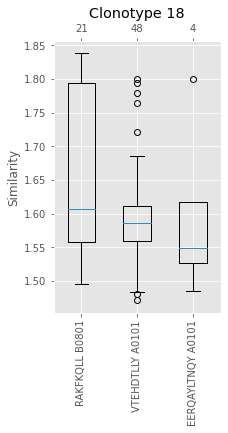

In [126]:
if pvalue < 0.05:
    test_result = ' (*)'
else:
    test_result = ''

plt.figure(figsize=(3,5))
plt.boxplot(scores, labels=peptides, widths=[0.5]*len(scores))
plt.title('Clonotype %s%s'%(clonotype, test_result))
#plt.xlim(0.6, 2.4)
plt.ylabel("Similarity")
plt.xticks(rotation=90)
ax = plt.gca()

ax_t = ax.secondary_xaxis('top')
ax_t.set_xticks(np.arange(1,len(scores)+1))
ax_t.set_xticklabels([len(s) for s in scores])

plt.savefig('anova.%s.pdf'%clonotype, bbox_inches='tight')
plt.show()

In [195]:
[len(s) for s in scores]

[9, 4, 28, 74]

# Overview of beta chain redundancy

In [144]:
def assign_marker(row):
    if row.con_comp & row.con_miss:
        marker = "D"
    elif row.con_comp & ~row.con_miss:
        marker = 11
    elif ~row.con_comp & row.con_miss:
        marker = 8
    elif ~row.con_comp & ~row.con_miss:
        marker = "X"
    return marker

In [147]:
def mscatter(x,y,ax=None, m=None, **kw):
    import matplotlib.markers as mmarkers
    if not ax: ax=plt.gca()
    sc = ax.scatter(x,y,**kw)
    if (m is not None) and (len(m)==len(x)):
        paths = []
        for marker in m:
            if isinstance(marker, mmarkers.MarkerStyle):
                marker_obj = marker
            else:
                marker_obj = mmarkers.MarkerStyle(marker)
            path = marker_obj.get_path().transformed(
                        marker_obj.get_transform())
            paths.append(path)
        sc.set_paths(paths)
    return sc

In [165]:
subst = trash.copy()
data = 'trash'

In [173]:
miss_chain_tcrs = sorted(subst[subst.single_chain_only].ct.unique())
both_chain_tcrs = sorted(subst[~subst.single_chain_only].ct.unique())

shared_beta = pd.DataFrame(columns=miss_chain_tcrs, index=both_chain_tcrs)

miss_chain_df = subst[subst.ct.isin(miss_chain_tcrs)]
for i, row in shared_beta.iterrows():
    miss_chain_shared = miss_chain_df[miss_chain_df.cdr3_TRB.isin(subst[subst.ct == i].cdr3_TRB)].ct.unique()
    shared_beta.loc[i, miss_chain_shared] = 1

lol = shared_beta.reset_index(drop=False).rename(columns={'index':'ct'})

lolz = pd.melt(lol, id_vars=['ct'], value_vars=lol.columns[1:], var_name='missing').dropna()

grp = subst[subst.ct.isin(lolz.ct)].sort_values(by=['ct','binding_concordance']).drop_duplicates(subset=['ct'], keep='last').groupby('ct')
dct = grp.peptide_HLA.unique().apply(lambda x: 'multiple' if len(x) > 1 else x[0]).to_dict()
lolz['pep_comp'] = lolz.ct.map(dct)
dct = grp.binding_concordance.max().apply(lambda x: True if x == 1 else False).to_dict()
lolz['con_comp'] = lolz.ct.map(dct)

grp = subst[subst.ct.isin(lolz.missing)].sort_values(by=['ct','binding_concordance']).drop_duplicates(subset=['ct'], keep='last').groupby('ct')
dct = grp.peptide_HLA.unique().apply(lambda x: 'multiple' if len(x) > 1 else x[0]).to_dict()
lolz['pep_miss'] = lolz.missing.map(dct)
dct = grp.binding_concordance.max().apply(lambda x: True if x == 1 else False).to_dict()
lolz['con_miss'] = lolz.missing.map(dct)

peptide_lst = list(set(lolz['pep_comp']).union(set(lolz['pep_miss'])))
if data == 'total':
    colors = ['#d7191c','#fdae61','#ffffbf','#abdda4','#2b83ba']
elif data == 'trash':
    colors = ['#9e0142','#d53e4f','#f46d43','#fdae61','#fee08b','#ffffbf','#e6f598','#abdda4','#66c2a5','#3288bd','#5e4fa2', 'magenta']
dct = dict(zip(peptide_lst, colors))
lolz['col_comp'] = lolz.pep_comp.map(dct)
lolz['col_miss'] = lolz.pep_miss.map(dct)

lolz['marker'] = lolz.apply(lambda row: assign_marker(row), axis=1)

In [174]:
peptide_lst

['FSAGAFILYK A0101',
 'GLFSAGAFIL A2401',
 'SSGYRIGQF B0801',
 'KVPAQRLQEA B0702',
 'GPFPGNLVDV B0702',
 'EERQAYLTNQY A0101',
 'SAGAFILYK A0101',
 'TPRVTGGGAM B0702',
 'FLVNTMCLAL A0201',
 'TADVDAGSLS A0101',
 'RAKFKQLL B0801',
 'VTEHDTLLY A0101']

In [175]:
lolz

,ct,missing,value,pep_comp,con_comp,pep_miss,con_miss,col_comp,col_miss,marker
1,2.0,4.0,1,VTEHDTLLY A0101,False,VTEHDTLLY A0101,False,magenta,magenta,X
9,18.0,4.0,1,RAKFKQLL B0801,False,VTEHDTLLY A0101,False,#5e4fa2,magenta,X
24,39.0,4.0,1,VTEHDTLLY A0101,False,VTEHDTLLY A0101,False,magenta,magenta,X
92,225.0,4.0,1,VTEHDTLLY A0101,True,VTEHDTLLY A0101,False,magenta,magenta,11
439,6.0,7.0,1,VTEHDTLLY A0101,False,VTEHDTLLY A0101,False,magenta,magenta,X
477,67.0,7.0,1,VTEHDTLLY A0101,True,VTEHDTLLY A0101,False,magenta,magenta,11
478,68.0,7.0,1,VTEHDTLLY A0101,False,VTEHDTLLY A0101,False,magenta,magenta,X
501,131.0,7.0,1,VTEHDTLLY A0101,True,VTEHDTLLY A0101,False,magenta,magenta,11
604,583.0,7.0,1,VTEHDTLLY A0101,True,VTEHDTLLY A0101,False,magenta,magenta,11
605,585.0,7.0,1,VTEHDTLLY A0101,True,VTEHDTLLY A0101,False,magenta,magenta,11


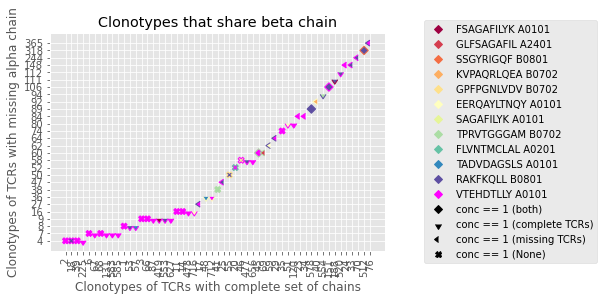

In [176]:
fig = plt.figure() #figsize=(10, 10)

x = lolz.ct.astype(int).astype(str)
y = lolz.missing.astype(int).astype(str)
m = lolz.marker
f = lolz.col_comp
e = lolz.col_miss

mscatter(x, y, m=m, facecolor=f, edgecolors=e, linewidth=1)
#plt.scatter(lolz.ct.astype(int).astype(str), lolz.missing.astype(int).astype(str), facecolor=lolz.col_comp, edgecolors=lolz.col_miss)

plt.xlabel('Clonotypes of TCRs with complete set of chains')
plt.ylabel('Clonotypes of TCRs with missing alpha chain')
plt.title('Clonotypes that share beta chain')

plt.xticks(rotation=90)


f = lambda m,c: plt.plot([],[], marker=m, color=c, ls="none")[0]

handles = [f("D", color) for color in colors]
handles += [f(marker, "k") for marker in ['D', 11, 8, 'X']]

labels = peptide_lst + ["conc == 1 (both)",
                        "conc == 1 (complete TCRs)",
                        "conc == 1 (missing TCRs)",
                        "conc == 1 (None)"]

plt.legend(handles, labels, bbox_to_anchor=(1.1, 0.5), loc='center left')

plt.savefig('%s.ct_sharing_chain.pdf' %data, bbox_inches='tight')
plt.show()

hej
{640, 512, 1026, 2307, 649, 906, 781, 2189, 1935, 910, 2197, 1174, 800, 929, 2212, 680, 2346, 2091, 304, 1333, 2357, 442, 827, 2119, 72, 2250, 2387, 980, 350, 1631, 480, 2143, 1250, 2402, 998, 2024, 2154, 1517, 749, 1391, 2422, 1402, 2302}


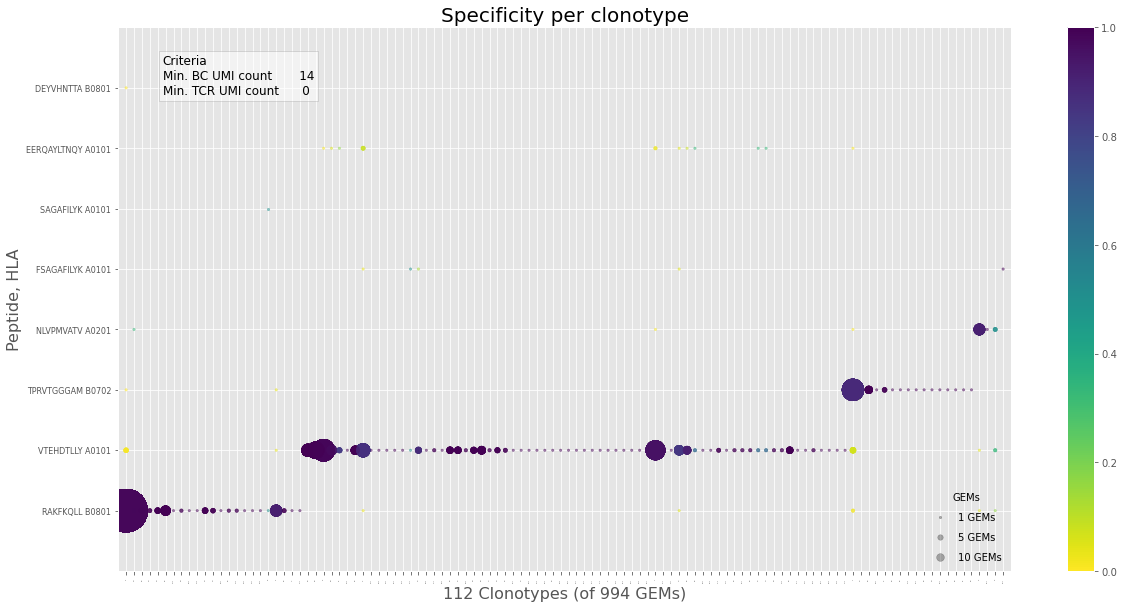

OBS! Figures are not saved!


In [16]:
tmp = df[(df.umi_count_mhc >= 14) & (df.delta_umi_mhc >= 4) & (df.delta_umi_TRB >= 2)].copy()
peptide_per_clonotype_by_gem_size(tmp,
                                  clonotype_fmt='ct',
                                  bc_threshold=14, tcr_threshold=0, save_tuba='specificity.umi_mhc_14.delta_mhc_4.pdf')

In [19]:
tmp.loc[tmp.ct == 19,['ct','peptide_HLA','peptide_lst','umi_count_lst_mhc','delta_umi_mhc','umi_count_lst_TRA','delta_umi_TRA','umi_count_lst_TRB','delta_umi_TRB']].head(60)

,ct,peptide_HLA,peptide_lst,umi_count_lst_mhc,delta_umi_mhc,umi_count_lst_TRA,delta_umi_TRA,umi_count_lst_TRB,delta_umi_TRB
2154,19.0,EERQAYLTNQY A0101,['CSSVDIHF' 'FSAGAFILYK' 'NLVPMVATV' 'SAGAFILY...,"[1, 1, 1, 1, 2, 46]",20.444444,[],NaN,[16],64.0
2400,19.0,VTEHDTLLY A0101,['SVDIHFDPG' 'FSAGAFILYN' 'ATTADVDAGSL' 'VTEHD...,"[1, 1, 1, 49]",39.200000,[],NaN,[7],28.0


## Make linear model

In [54]:
X = table[['umi_count_TRA','delta_umi_TRA',
            'umi_count_TRB','delta_umi_TRB',
            'umi_count_mhc','delta_umi_mhc']]

In [55]:
Y = table.accuracy

In [56]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=101)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(276480, 6)
(184320, 6)
(276480,)
(184320,)


In [57]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

In [58]:
print(model.intercept_)

0.9065629127114576


In [59]:
coeff_parameter = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
coeff_parameter

,Coefficient
umi_count_TRA,-0.000406
delta_umi_TRA,0.000072
umi_count_TRB,0.002288
delta_umi_TRB,0.000279
umi_count_mhc,0.001470
delta_umi_mhc,0.002308


/Users/herpov/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='accuracy'>

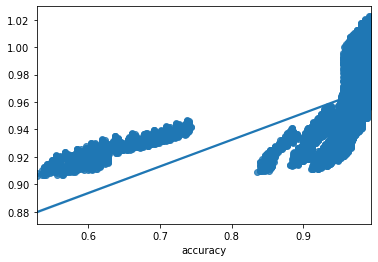

In [60]:
predictions = model.predict(X_test)
sns.regplot(y_test, predictions)

In [113]:
import statsmodels.api as sm

ModuleNotFoundError: No module named 'statsmodels'

In [158]:
tmp.ct.unique().shape

(112,)